In [ ]:
# --- CELDA 1: SETUP, DESCARGAS Y DEFINICIONES INICIALES (CORREGIDA) ---

# 0. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 1. Instalación de dependencias (se ejecuta solo una vez)
!pip install -U ultralytics seaborn pyyaml matplotlib roboflow==1.1.64 --quiet

# 2. Imports y configuración de logging
import logging
from pathlib import Path
from roboflow import Roboflow # Para descargar de Roboflow
import shutil # Para posible limpieza de directorios

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s"
)
print("--- [CELDA 1] SETUP, DESCARGAS Y DEFINICIONES INICIALES (CORREGIDA) ---")
logging.info("--- [CELDA 1] SETUP, DESCARGAS Y DEFINICIONES INICIALES (CORREGIDA) ---")

# --- Definiciones Clave ---
API_KEY = "tZR7XZhFvySrbVM3hfH4"
RAW_DIR = Path("/content/datasets_raw_temp")
# Limpiar RAW_DIR al inicio para asegurar descargas frescas si es necesario (opcional)
# if RAW_DIR.exists():
#     logging.info(f"Limpiando directorio RAW_DIR existente: {RAW_DIR}")
#     shutil.rmtree(RAW_DIR)
RAW_DIR.mkdir(parents=True, exist_ok=True)
logging.info(f"Los datasets crudos se descargarán en: {RAW_DIR}")

FINAL_PROCESSED_DATASET_ON_DRIVE = Path("/content/drive/MyDrive/Coffee_Processed_3_Datasets_v2") # Nombre ajustado
FINAL_PROCESSED_DATASET_ON_DRIVE.mkdir(parents=True, exist_ok=True)
logging.info(f"El dataset procesado final se guardará en Drive en: {FINAL_PROCESSED_DATASET_ON_DRIVE}")

UNIFIED_CLASS_LIST = ['Inmaduro', 'Pinton', 'Maduro', 'Sobremaduro', 'Seco']
UNIFIED_CLASS_TO_IDX = {name: i for i, name in enumerate(UNIFIED_CLASS_LIST)}
EXCLUDE_CLASS_NAME = 'Enfermo'

# --- Descarga de Datasets Crudos ---
try:
    rf = Roboflow(api_key=API_KEY)
    logging.info("Roboflow SDK inicializado correctamente.")
except Exception as e_rf:
    logging.error(f"Error al inicializar Roboflow SDK: {e_rf}. Verifica tu API Key.")
    raise RuntimeError("Fallo al inicializar Roboflow SDK") from e_rf


# 4. Lista de proyectos y versiones a descargar (ACTUALIZADA A 4 DATASETS)
projects_to_download = [
    ("wys-amyvz", "coffee-cherries-qpktr", 1),
    ("ciencia-cafeto", "coffee-fruit-maturity-befkg", 5),
    ("coffeeclassification-reduced", "coffeeclassification", 1),
    ("valentinaosorio", "coffe_fobv2", 5), # <-- NUEVO DATASET AÑADIDO
]
logging.info(f"Se intentará descargar/verificar {len(projects_to_download)} datasets.")
print(f"Se descargarán los siguientes {len(projects_to_download)} datasets:")
for ws, proj, ver in projects_to_download:
    print(f"  - Workspace: {ws}, Proyecto: {proj}, Versión: {ver}")

logging.info(f"--- Iniciando descarga de datasets crudos a {RAW_DIR} ---")
datasets_processed_count = 0
for workspace, project_name, version_number in projects_to_download:
    # Nombre de la carpeta destino como tú lo esperas (ej: project_v1)
    dest_folder_name = f"{project_name}_v{version_number}"
    dest_path = RAW_DIR / dest_folder_name

    # Si la carpeta destino ya existe Y CONTIENE ARCHIVOS, se salta.
    # Esto es importante para no re-descargar si ya está completo.
    if dest_path.exists() and any(dest_path.iterdir()):
        logging.info(f"✔️  Dataset '{dest_folder_name}' ya existe en {dest_path} y no está vacío. Saltando descarga.")
        print(f"✔️  Dataset '{dest_folder_name}' ya existe y no está vacío. Saltando.")
        datasets_processed_count += 1
        continue

    # Si la carpeta existe pero está vacía, o no existe, procedemos a descargar.
    # Roboflow creará la carpeta 'dest_path' si no existe y descargará el contenido DENTRO de ella.
    logging.info(f"⬇️  Descargando '{project_name}' v{version_number} en la carpeta '{dest_path}'...")
    print(f"⬇️  Descargando '{project_name}' v{version_number} en '{dest_path}'...")
    try:
        project_instance = rf.workspace(workspace).project(project_name)
        version_instance = project_instance.version(version_number)

        # Usar location=str(dest_path) para que Roboflow descargue DENTRO de esa carpeta.
        # Roboflow crea la carpeta `dest_path` si no existe.
        version_instance.download("yolov8", location=str(dest_path))

        # Verificar si la descarga fue exitosa y la carpeta contiene datos
        if dest_path.exists() and any(dest_path.iterdir()):
            logging.info(f"✅  Descargado '{dest_folder_name}' en {dest_path}")
            print(f"✅  Descargado '{dest_folder_name}'")
            datasets_processed_count += 1
        else:
            logging.error(f"❌  Error post-descarga: La carpeta '{dest_folder_name}' no se creó o está vacía en {dest_path} después de intentar descargar.")
            print(f"❌  Error post-descarga: La carpeta '{dest_folder_name}' no se creó o está vacía.")

    except Exception as e_download:
        logging.error(f"❌  Error crítico al descargar {project_name}_v{version_number}: {e_download}")
        print(f"❌  Error crítico al descargar {project_name}_v{version_number}: {e_download}")
        try:
            project_check = rf.workspace(workspace).project(project_name)
            version_check = project_check.version(version_number)
            logging.error(f"    Detalles de la versión (Roboflow): Nombre='{version_check.name}', ID='{version_check.id}', Formatos='{getattr(version_check, 'model_formats', 'N/A')}'")
        except Exception as e_details_rf:
            logging.error(f"    No se pudieron obtener detalles adicionales de la versión de Roboflow: {e_details_rf}")

# --- Verificación Final ---
logging.info(f"--- Verificación final de directorios en {RAW_DIR}: ---")
actual_dirs_in_raw = sorted([d for d in RAW_DIR.iterdir() if d.is_dir() and any(d.iterdir())]) # Solo directorios no vacíos

if not actual_dirs_in_raw:
    logging.warning("⚠️ RAW_DIR está vacío o todos los subdirectorios están vacíos.")
    print("⚠️ RAW_DIR está vacío o todos los subdirectorios están vacíos. Revisa los logs.")
else:
    print(f"Directorios de datasets (no vacíos) encontrados en {RAW_DIR}:")
    for sub_dir in actual_dirs_in_raw:
        logging.info(f"  • Directorio confirmado: {sub_dir.name}")
        print(f"  • {sub_dir.name}")

if datasets_processed_count == len(projects_to_download):
    logging.info(f"--- Descarga/verificación de los {len(projects_to_download)} datasets solicitados completada. ---")
    print(f"--- Descarga/verificación de los {len(projects_to_download)} datasets solicitados completada. ---")
else:
    logging.warning(f"--- Descarga intentada. Se procesaron/encontraron {datasets_processed_count} de {len(projects_to_download)} datasets. Revisa logs para errores. ---")
    print(f"--- Descarga intentada. Se procesaron/encontraron {datasets_processed_count} de {len(projects_to_download)} datasets. Revisa logs para errores. ---")

print("\n--- FIN DE CELDA 1 ---")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━


Extracting Dataset Version Zip to /content/datasets_raw_temp/coffee-cherries-qpktr_v1 in yolov8:: 100%|██████████| 4128/4128 [00:00<00:00, 4441.30it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅  Descargado 'coffee-cherries-qpktr_v1'
⬇️  Descargando 'coffee-fruit-maturity-befkg' v5 en '/content/datasets_raw_temp/coffee-fruit-maturity-befkg_v5'...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/datasets_raw_temp/coffee-fruit-maturity-befkg_v5 in yolov8:: 100%|██████████| 4732/4732 [00:00<00:00, 5157.65it/s]


✅  Descargado 'coffee-fruit-maturity-befkg_v5'
⬇️  Descargando 'coffeeclassification' v1 en '/content/datasets_raw_temp/coffeeclassification_v1'...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/datasets_raw_temp/coffeeclassification_v1 in yolov8:: 100%|██████████| 312/312 [00:00<00:00, 3620.19it/s]

✅  Descargado 'coffeeclassification_v1'
⬇️  Descargando 'coffe_fobv2' v5 en '/content/datasets_raw_temp/coffe_fobv2_v5'...
loading Roboflow workspace...


loading Roboflow project...



Extracting Dataset Version Zip to /content/datasets_raw_temp/coffe_fobv2_v5 in yolov8:: 100%|██████████| 4224/4224 [00:01<00:00, 2855.27it/s]


✅  Descargado 'coffe_fobv2_v5'
Directorios de datasets (no vacíos) encontrados en /content/datasets_raw_temp:
  • coffe_fobv2_v5
  • coffee-cherries-qpktr_v1
  • coffee-fruit-maturity-befkg_v5
  • coffeeclassification_v1
--- Descarga/verificación de los 4 datasets solicitados completada. ---

--- FIN DE CELDA 1 ---


In [ ]:
import yaml # Para leer archivos YAML
from pathlib import Path
import logging

# --- Configuración (Asegúrate que RAW_DIR esté definido) ---
# Si RAW_DIR no está definido globalmente, descomenta y ajusta la siguiente línea:
# RAW_DIR = Path("/content/datasets_raw_temp")

# Configurar logging si no se ha hecho antes o para asegurar la salida
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s",
    force=True
)
print("--- SCRIPT PARA LISTAR CLASES ORIGINALES DE CADA DATASET ---")

if 'RAW_DIR' not in globals() or not isinstance(RAW_DIR, Path) or not RAW_DIR.exists():
    error_msg = (
        "ERROR CRÍTICO: La variable RAW_DIR no está definida correctamente. "
        "Asegúrate de que RAW_DIR sea un objeto Path y que la ruta exista. "
        f"Valor actual: {RAW_DIR if 'RAW_DIR' in globals() else 'No definida'}"
    )
    print(error_msg)
    logging.error(error_msg)
else:
    logging.info(f"Buscando datasets y sus archivos data.yaml en: {RAW_DIR}")
    print(f"\nListado de clases originales por dataset en: {RAW_DIR}")

    dataset_folders = sorted([d for d in RAW_DIR.iterdir() if d.is_dir()])

    if not dataset_folders:
        warning_msg = f"No se encontraron directorios de datasets en {RAW_DIR}."
        print(warning_msg)
        logging.warning(warning_msg)
    else:
        for dataset_path in dataset_folders:
            print(f"\nDataset: {dataset_path.name}")
            logging.info(f"Procesando dataset: {dataset_path.name}")

            data_yaml_file = dataset_path / "data.yaml"

            if data_yaml_file.exists():
                try:
                    with open(data_yaml_file, 'r') as f:
                        dataset_config = yaml.safe_load(f)

                        if 'names' in dataset_config and isinstance(dataset_config['names'], list):
                            class_names = dataset_config['names']
                            print(f"  Clases encontradas ({len(class_names)}):")
                            for i, name in enumerate(class_names):
                                print(f"    {i}: {name}")
                            logging.info(f"  Dataset '{dataset_path.name}' - Clases: {class_names}")
                        else:
                            warning_msg = f"  El archivo data.yaml en '{dataset_path.name}' no contiene una lista de clases ('names') o el formato es incorrecto."
                            print(warning_msg)
                            logging.warning(warning_msg)
                            # Intentar buscar _classes.txt como alternativa (menos común para YOLOv8 de Roboflow pero posible)
                            classes_txt_file = dataset_path / "_classes.txt"
                            if classes_txt_file.exists():
                                try:
                                    with open(classes_txt_file, 'r') as cf:
                                        class_names_from_txt = [line.strip() for line in cf if line.strip()]
                                    if class_names_from_txt:
                                        print(f"  Clases encontradas en _classes.txt ({len(class_names_from_txt)}):")
                                        for i, name in enumerate(class_names_from_txt):
                                            print(f"    {i}: {name}")
                                        logging.info(f"  Dataset '{dataset_path.name}' - Clases (de _classes.txt): {class_names_from_txt}")
                                    else:
                                        print("    _classes.txt está vacío.")
                                        logging.info(f"   _classes.txt en '{dataset_path.name}' está vacío.")
                                except Exception as e_txt:
                                    print(f"    Error leyendo _classes.txt en '{dataset_path.name}': {e_txt}")
                                    logging.error(f"    Error leyendo _classes.txt en '{dataset_path.name}': {e_txt}")


                except yaml.YAMLError as e_yaml:
                    error_msg_yaml = f"  Error al parsear data.yaml en '{dataset_path.name}': {e_yaml}"
                    print(error_msg_yaml)
                    logging.error(error_msg_yaml)
                except Exception as e_gen:
                    error_msg_gen = f"  Ocurrió un error inesperado con data.yaml en '{dataset_path.name}': {e_gen}"
                    print(error_msg_gen)
                    logging.error(error_msg_gen)
            else:
                warning_msg_no_yaml = f"  ADVERTENCIA: No se encontró el archivo data.yaml en '{dataset_path.name}'."
                print(warning_msg_no_yaml)
                logging.warning(warning_msg_no_yaml)
                # También podrías buscar aquí _classes.txt si data.yaml no existe.

print("\n--- FIN DEL LISTADO DE CLASES ORIGINALES ---")

2025-06-07 01:37:53,426 INFO: Buscando datasets y sus archivos data.yaml en: /content/datasets_raw_temp
2025-06-07 01:37:53,427 INFO: Procesando dataset: coffe_fobv2_v5
2025-06-07 01:37:53,430 INFO:   Dataset 'coffe_fobv2_v5' - Clases: ['overripe', 'ripe', 'semi_ripe', 'unripe']
2025-06-07 01:37:53,431 INFO: Procesando dataset: coffee-cherries-qpktr_v1
2025-06-07 01:37:53,435 INFO:   Dataset 'coffee-cherries-qpktr_v1' - Clases: ['0', '1', '2', '3', '4']
2025-06-07 01:37:53,435 INFO: Procesando dataset: coffee-fruit-maturity-befkg_v5
2025-06-07 01:37:53,437 INFO:   Dataset 'coffee-fruit-maturity-befkg_v5' - Clases: ['dry', 'overripe', 'ripe', 'semi_ripe', 'unripe']
2025-06-07 01:37:53,438 INFO: Procesando dataset: coffeeclassification_v1
2025-06-07 01:37:53,441 INFO:   Dataset 'coffeeclassification_v1' - Clases: ['diseased', 'dry', 'overripe', 'ripe', 'semi_ripe', 'unripe']


--- SCRIPT PARA LISTAR CLASES ORIGINALES DE CADA DATASET ---

Listado de clases originales por dataset en: /content/datasets_raw_temp

Dataset: coffe_fobv2_v5
  Clases encontradas (4):
    0: overripe
    1: ripe
    2: semi_ripe
    3: unripe

Dataset: coffee-cherries-qpktr_v1
  Clases encontradas (5):
    0: 0
    1: 1
    2: 2
    3: 3
    4: 4

Dataset: coffee-fruit-maturity-befkg_v5
  Clases encontradas (5):
    0: dry
    1: overripe
    2: ripe
    3: semi_ripe
    4: unripe

Dataset: coffeeclassification_v1
  Clases encontradas (6):
    0: diseased
    1: dry
    2: overripe
    3: ripe
    4: semi_ripe
    5: unripe

--- FIN DEL LISTADO DE CLASES ORIGINALES ---


2025-06-07 01:38:30,944 INFO: --- [CELDA 2] UNIFICACIÓN Y MAPEO DE ETIQUETAS (PARA 4 DATASETS) ---
2025-06-07 01:38:30,960 INFO: Directorio de entrada (datasets crudos): /content/datasets_raw_temp
2025-06-07 01:38:30,963 INFO: El dataset unificado (con 4 fuentes) se guardará en: /content/dataset_unified_temp_4datasets
2025-06-07 01:38:30,971 INFO: Clases Unificadas: ['Inmaduro', 'Pinton', 'Maduro', 'Sobremaduro', 'Seco']
2025-06-07 01:38:30,972 INFO: Mapa de Clase a Índice Unificado: {'Inmaduro': 0, 'Pinton': 1, 'Maduro': 2, 'Sobremaduro': 3, 'Seco': 4}
2025-06-07 01:38:30,976 INFO: Configuración de mapeo de etiquetas cargada para 4 datasets fuente.
2025-06-07 01:38:30,982 INFO: Estructura de directorios para dataset unificado preparada en: /content/dataset_unified_temp_4datasets
2025-06-07 01:38:30,993 INFO: Se procesarán 4 datasets desde /content/datasets_raw_temp: ['coffe_fobv2_v5', 'coffee-cherries-qpktr_v1', 'coffee-fruit-maturity-befkg_v5', 'coffeeclassification_v1']
2025-06-07 0

--- [CELDA 2] UNIFICACIÓN Y MAPEO DE ETIQUETAS (PARA 4 DATASETS) ---


2025-06-07 01:38:33,842 INFO:     Split 'train': 2109 imágenes encontradas, 1598 archivos de etiquetas con contenido válido escritos.
2025-06-07 01:38:33,845 INFO: 
--- Procesando Dataset Crudo: coffee-cherries-qpktr_v1 (base: coffee-cherries-qpktr) ---
2025-06-07 01:38:33,850 INFO:   Clases originales del data.yaml para 'coffee-cherries-qpktr_v1': ['0', '1', '2', '3', '4']
2025-06-07 01:38:33,862 INFO:     Clase original '0' (idx 0) se mapeará a 'Seco' (unif. idx 4).
2025-06-07 01:38:33,863 INFO:     Clase original '1' (idx 1) se mapeará a 'Sobremaduro' (unif. idx 3).
2025-06-07 01:38:33,864 INFO:     Clase original '2' (idx 2) se mapeará a 'Maduro' (unif. idx 2).
2025-06-07 01:38:33,866 INFO:     Clase original '3' (idx 3) se mapeará a 'Pinton' (unif. idx 1).
2025-06-07 01:38:33,868 INFO:     Clase original '4' (idx 4) se mapeará a 'Inmaduro' (unif. idx 0).
2025-06-07 01:38:33,871 INFO:   Procesando split 'train' de 'coffee-cherries-qpktr_v1'...
2025-06-07 01:38:35,728 INFO:     Spli

Archivo YAML para el dataset unificado creado en: /content/dataset_unified_temp_4datasets/data_unified_4datasets.yaml

--- Distribución de Clases en el Dataset Unificado LOCAL (dataset_unified_temp_4datasets) ---
Clase 'Inmaduro' (índice unificado 0): 45976 instancias en 3950 imágenes
Clase 'Pinton' (índice unificado 1): 4997 instancias en 1114 imágenes
Clase 'Maduro' (índice unificado 2): 7548 instancias en 1333 imágenes
Clase 'Sobremaduro' (índice unificado 3): 10179 instancias en 2130 imágenes
Clase 'Seco' (índice unificado 4): 2476 instancias en 682 imágenes


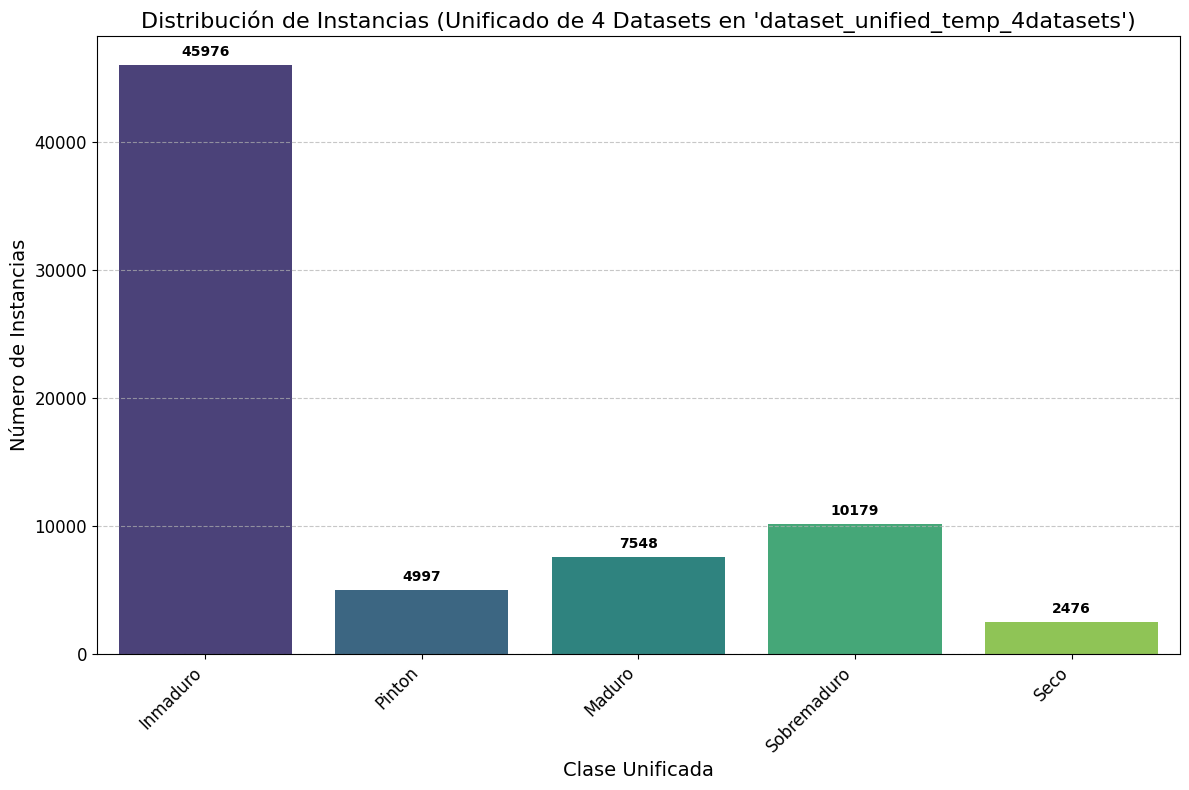

2025-06-07 01:38:41,031 INFO: --- Unificación (4 datasets) en directorio local /content/dataset_unified_temp_4datasets completada. ---


--- Unificación (4 datasets) en directorio local /content/dataset_unified_temp_4datasets completada. ---


In [ ]:
# --- CELDA 2: UNIFICACIÓN Y MAPEO DE ETIQUETAS (PARA 4 DATASETS) ---

import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import shutil
import logging

# --- 0. Configuración de Logging (asegurar que esté activo) ---
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s",
    force=True
)
print("--- [CELDA 2] UNIFICACIÓN Y MAPEO DE ETIQUETAS (PARA 4 DATASETS) ---")
logging.info("--- [CELDA 2] UNIFICACIÓN Y MAPEO DE ETIQUETAS (PARA 4 DATASETS) ---")

# --- 1. Definiciones Clave ---
# RAW_DIR debe estar definida por la Celda 1 y contener los 4 datasets descargados.
if 'RAW_DIR' not in globals() or not isinstance(RAW_DIR, Path) or not RAW_DIR.exists():
    logging.error(f"ERROR CRÍTICO: RAW_DIR no está definido o no existe. Ejecuta la Celda 1 primero.")
    raise NameError("RAW_DIR no definido o no existe.")
logging.info(f"Directorio de entrada (datasets crudos): {RAW_DIR}")

# Directorio para el dataset unificado temporal
LOCAL_UNIFIED_DIR = Path("/content/dataset_unified_temp_4datasets") # Nuevo nombre para evitar confusiones
LOCAL_UNIFIED_DIR.mkdir(parents=True, exist_ok=True)
logging.info(f"El dataset unificado (con 4 fuentes) se guardará en: {LOCAL_UNIFIED_DIR}")

# UNIFIED_CLASS_LIST y UNIFIED_CLASS_TO_IDX deben estar definidas (usualmente desde Celda 1)
if 'UNIFIED_CLASS_LIST' not in globals() or 'UNIFIED_CLASS_TO_IDX' not in globals():
    logging.info("UNIFIED_CLASS_LIST o UNIFIED_CLASS_TO_IDX no definidas globalmente. Definiéndolas ahora.")
    UNIFIED_CLASS_LIST = ['Inmaduro', 'Pinton', 'Maduro', 'Sobremaduro', 'Seco']
    UNIFIED_CLASS_TO_IDX = {name: i for i, name in enumerate(UNIFIED_CLASS_LIST)}
logging.info(f"Clases Unificadas: {UNIFIED_CLASS_LIST}")
logging.info(f"Mapa de Clase a Índice Unificado: {UNIFIED_CLASS_TO_IDX}")

# new_label_maps_config ACTUALIZADO para los 4 datasets que estás usando:
new_label_maps_config = {
    "coffee-cherries-qpktr": {
        '0': 'Seco',
        '1': 'Sobremaduro',
        '2': 'Maduro',
        '3': 'Pinton',
        '4': 'Inmaduro'
    },
    "coffee-fruit-maturity-befkg": {
        'dry': 'Seco',
        'overripe': 'Sobremaduro',
        'ripe': 'Maduro',
        'semi_ripe': 'Pinton',
        'unripe': 'Inmaduro'
    },
    "coffeeclassification": {
        'diseased': None,       # ELIMINARESTA
        'dry': 'Seco',
        'overripe': 'Sobremaduro',
        'ripe': 'Maduro',
        'semi_ripe': 'Pinton',
        'unripe': 'Inmaduro'
    },
    "coffe_fobv2": {
        # <<< NUEVA REGLA PARA EL NUEVO DATASET >>>
        # Solo mapeamos 'overripe'. El script ignorará las otras clases de este dataset
        # porque no las encontrará en este mapa.
        'overripe': 'Sobremaduro'
    }
}
logging.info(f"Configuración de mapeo de etiquetas cargada para {len(new_label_maps_config)} datasets fuente.")

# --- 2. Preparación de la Estructura de Directorios Locales ---
# (Esta sección no necesita cambios)
local_unified_images_dir = LOCAL_UNIFIED_DIR / "images"
local_unified_labels_dir = LOCAL_UNIFIED_DIR / "labels"
(local_unified_images_dir / "train").mkdir(parents=True, exist_ok=True)
(local_unified_images_dir / "valid").mkdir(parents=True, exist_ok=True)
(local_unified_labels_dir / "train").mkdir(parents=True, exist_ok=True)
(local_unified_labels_dir / "valid").mkdir(parents=True, exist_ok=True)
logging.info(f"Estructura de directorios para dataset unificado preparada en: {LOCAL_UNIFIED_DIR}")

# --- 3. Procesamiento y Unificación ---
# (El resto del script de aquí en adelante no necesita cambios,
#  ya que está diseñado para adaptarse al contenido de `new_label_maps_config`)

local_unified_label_counts = Counter()
images_per_unified_class = {i: set() for i in range(len(UNIFIED_CLASS_LIST))}

total_images_copied = 0
total_labels_processed_and_written = 0

# Filtrar para procesar solo los directorios de los datasets definidos en el mapa
expected_dataset_folder_bases = list(new_label_maps_config.keys())
datasets_to_process_paths = []
for d in RAW_DIR.iterdir():
    if d.is_dir():
        dir_base_name = d.name.split('_v')[0]
        if dir_base_name in expected_dataset_folder_bases:
            datasets_to_process_paths.append(d)
datasets_in_raw_dir = sorted(datasets_to_process_paths)

if not datasets_in_raw_dir:
    logging.warning(f"No se encontraron directorios de los datasets esperados en {RAW_DIR} para procesar.")
else:
    logging.info(f"Se procesarán {len(datasets_in_raw_dir)} datasets desde {RAW_DIR}: {[d.name for d in datasets_in_raw_dir]}")

    for dataset_path in datasets_in_raw_dir:
        dataset_folder_name = dataset_path.name
        dataset_base_name = dataset_folder_name.split('_v')[0]
        logging.info(f"\n--- Procesando Dataset Crudo: {dataset_folder_name} (base: {dataset_base_name}) ---")

        if dataset_base_name not in new_label_maps_config:
            logging.error(f"ERROR INESPERADO: No se encontró config de mapeo para '{dataset_base_name}'. Saltando.")
            continue

        current_class_map_for_dataset = new_label_maps_config[dataset_base_name]

        original_data_yaml_path = dataset_path / "data.yaml"
        original_class_names_list = []
        if original_data_yaml_path.exists():
            try:
                with open(original_data_yaml_path, 'r') as f:
                    data_yaml_content = yaml.safe_load(f)
                    original_class_names_list = data_yaml_content.get('names', [])
                if not original_class_names_list:
                    if 'nc' in data_yaml_content:
                        original_class_names_list = [str(i) for i in range(int(data_yaml_content['nc']))]
                        logging.info(f"  'names' no encontrado, usando nombres genéricos: {original_class_names_list}")
                    else:
                        logging.error(f"  'names' y 'nc' no encontrados en {original_data_yaml_path}. Saltando.")
                        continue
                logging.info(f"  Clases originales del data.yaml para '{dataset_folder_name}': {original_class_names_list}")
            except Exception as e:
                logging.error(f"  Error al leer {original_data_yaml_path}: {e}. Saltando.")
                continue
        else:
            logging.warning(f"  ADVERTENCIA: No se encontró 'data.yaml' en {dataset_path}. Saltando dataset.")
            continue

        idx_orig_to_idx_unified_map = {}
        for orig_idx, orig_class_name_str in enumerate(original_class_names_list):
            target_unified_name = current_class_map_for_dataset.get(orig_class_name_str)
            if target_unified_name is None:
                idx_orig_to_idx_unified_map[orig_idx] = None
                logging.info(f"    Clase original '{orig_class_name_str}' (idx {orig_idx}) se ELIMINARÁ/IGNORARÁ.")
            elif target_unified_name in UNIFIED_CLASS_TO_IDX:
                idx_orig_to_idx_unified_map[orig_idx] = UNIFIED_CLASS_TO_IDX[target_unified_name]
                logging.info(f"    Clase original '{orig_class_name_str}' (idx {orig_idx}) se mapeará a '{target_unified_name}' (unif. idx {idx_orig_to_idx_unified_map[orig_idx]}).")
            else:
                idx_orig_to_idx_unified_map[orig_idx] = -2
                logging.warning(f"    ADVERTENCIA: Clase original '{orig_class_name_str}' (idx {orig_idx}) tiene un mapeo a '{target_unified_name}' que NO ESTÁ en UNIFIED_CLASS_LIST. Se OMITIRÁ.")

        for split_type in ["train", "valid", "test"]:
            source_img_dir_split = dataset_path / split_type / "images"
            source_lbl_dir_split = dataset_path / split_type / "labels"
            target_unified_split_name = "valid" if split_type == "test" else split_type
            dest_img_dir_split_local = local_unified_images_dir / target_unified_split_name
            dest_lbl_dir_split_local = local_unified_labels_dir / target_unified_split_name

            if source_img_dir_split.exists() and source_lbl_dir_split.exists():
                logging.info(f"  Procesando split '{split_type}' de '{dataset_folder_name}'...")
                num_images_in_split_found = 0
                num_labels_written_in_split = 0

                for img_file_path in source_img_dir_split.iterdir():
                    if img_file_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']: continue

                    num_images_in_split_found += 1
                    unique_image_name = f"{dataset_folder_name}_{img_file_path.name}"
                    unique_label_name = f"{dataset_folder_name}_{img_file_path.stem}.txt"
                    destination_image_path = dest_img_dir_split_local / unique_image_name
                    original_label_file_path = source_lbl_dir_split / f"{img_file_path.stem}.txt"
                    new_label_lines_for_file = []
                    classes_in_this_image_after_map = set()

                    if original_label_file_path.exists():
                        with open(original_label_file_path, 'r') as f_lbl_orig:
                            for line in f_lbl_orig:
                                parts = line.strip().split()
                                if not parts: continue
                                try:
                                    original_class_idx = int(parts[0])
                                    if original_class_idx in idx_orig_to_idx_unified_map:
                                        final_unified_idx = idx_orig_to_idx_unified_map[original_class_idx]
                                        if final_unified_idx is not None and final_unified_idx >= 0:
                                            new_label_lines_for_file.append(f"{final_unified_idx} {' '.join(parts[1:])}")
                                            local_unified_label_counts[final_unified_idx] += 1
                                            classes_in_this_image_after_map.add(final_unified_idx)
                                except (ValueError, IndexError):
                                    logging.warning(f"    Error de formato en línea en {original_label_file_path.name}: '{line.strip()}'")

                    if new_label_lines_for_file:
                        try:
                            shutil.copy2(img_file_path, destination_image_path)
                            total_images_copied += 1
                            with open(dest_lbl_dir_split_local / unique_label_name, 'w') as f_new_lbl:
                                f_new_lbl.write("\n".join(new_label_lines_for_file) + "\n")
                            total_labels_processed_and_written +=1
                            num_labels_written_in_split +=1
                            for cls_idx in classes_in_this_image_after_map:
                                images_per_unified_class[cls_idx].add(unique_image_name)
                        except Exception as e_copy_write:
                            logging.error(f"    Error copiando/escribiendo {unique_image_name}: {e_copy_write}")

                logging.info(f"    Split '{split_type}': {num_images_in_split_found} imágenes encontradas, {num_labels_written_in_split} archivos de etiquetas con contenido válido escritos.")

    logging.info(f"\nProceso de unificación completado. Total imágenes copiadas: {total_images_copied}. Total archivos de etiquetas escritos: {total_labels_processed_and_written}")

# --- 4. Creación del `data.yaml` para el Dataset Unificado LOCAL ---
local_unified_data_yaml_content = {
    'path': str(LOCAL_UNIFIED_DIR.resolve()),
    'train': 'images/train', 'val': 'images/valid', 'names': UNIFIED_CLASS_LIST
}
local_unified_data_yaml_path = LOCAL_UNIFIED_DIR / "data_unified_4datasets.yaml"
try:
    with open(local_unified_data_yaml_path, 'w') as f:
        yaml.dump(local_unified_data_yaml_content, f, sort_keys=False, indent=2, default_flow_style=False)
    logging.info(f"Archivo '{local_unified_data_yaml_path.name}' creado en {LOCAL_UNIFIED_DIR}")
    print(f"Archivo YAML para el dataset unificado creado en: {local_unified_data_yaml_path}")
except Exception as e:
    logging.error(f"Error al escribir YAML unificado '{local_unified_data_yaml_path.name}': {e}")

# --- 5. Análisis del Dataset Unificado LOCAL ---
# (El código para imprimir distribución y graficar se mantiene igual que antes)
print(f"\n--- Distribución de Clases en el Dataset Unificado LOCAL ({LOCAL_UNIFIED_DIR.name}) ---")
logging.info(f"--- Distribución de Clases en el Dataset Unificado LOCAL ({LOCAL_UNIFIED_DIR.name}) ---")

if not local_unified_label_counts:
    print("No se encontraron etiquetas válidas en el dataset unificado local después del mapeo.")
else:
    for i in range(len(UNIFIED_CLASS_LIST)):
        class_name = UNIFIED_CLASS_LIST[i]
        instance_count = local_unified_label_counts.get(i, 0)
        image_count = len(images_per_unified_class.get(i, set()))
        print(f"Clase '{class_name}' (índice unificado {i}): {instance_count} instancias en {image_count} imágenes")
    # ... (El resto del código para la gráfica se mantiene igual)
    plot_class_names = UNIFIED_CLASS_LIST
    plot_instance_counts = [local_unified_label_counts.get(UNIFIED_CLASS_TO_IDX[name], 0) for name in plot_class_names]

    if any(c > 0 for c in plot_instance_counts):
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x=plot_class_names, y=plot_instance_counts, hue=plot_class_names, palette="viridis", legend=False)
        plt.title(f"Distribución de Instancias (Unificado de 4 Datasets en '{LOCAL_UNIFIED_DIR.name}')", fontsize=16)
        plt.xlabel("Clase Unificada", fontsize=14)
        plt.ylabel("Número de Instancias", fontsize=14)
        plt.xticks(rotation=45, ha="right", fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        max_val = max(plot_instance_counts) if plot_instance_counts else 0
        for i_bar, v_bar in enumerate(plot_instance_counts):
            if v_bar > 0 :
                 ax.text(i_bar, v_bar + (0.01 * max_val) + 1, str(v_bar), color='black', ha='center', va='bottom', fontweight='bold', fontsize=10)
        plt.tight_layout()
        plt.show()
    else:
        print("No hay datos de instancias para graficar.")

logging.info(f"--- Unificación (4 datasets) en directorio local {LOCAL_UNIFIED_DIR} completada. ---")
print(f"--- Unificación (4 datasets) en directorio local {LOCAL_UNIFIED_DIR} completada. ---")

In [ ]:
# --- CELDA 2.5: DIAGNÓSTICO DEL LOCAL_UNIFIED_DIR (SALIDA DE CELDA 2) ---

from pathlib import Path
from collections import Counter
import yaml
import logging

# --- 0. Configuración de Logging (asegurar que esté activo) ---
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s",
    force=True
)
print("--- CELDA 2.5: DIAGNÓSTICO DE CONTEOS EN LOCAL_UNIFIED_DIR ---")
logging.info("--- CELDA 2.5: DIAGNÓSTICO DE CONTEOS EN LOCAL_UNIFIED_DIR ---")

# --- 1. Verificación de Directorios y Carga de Clases ---

# Directorio a verificar (debe ser la SALIDA de tu Celda 2)
# LOCAL_UNIFIED_DIR ya debería estar definido por la Celda 2.
if 'LOCAL_UNIFIED_DIR' not in globals() or not isinstance(LOCAL_UNIFIED_DIR, Path) or not LOCAL_UNIFIED_DIR.exists():
    error_msg = (
        f"ERROR CRÍTICO: LOCAL_UNIFIED_DIR no está definido o no existe. "
        f"Ejecuta la Celda 2 primero. "
        f"Valor actual: {LOCAL_UNIFIED_DIR if 'LOCAL_UNIFIED_DIR' in globals() else 'No definida'}"
    )
    print(error_msg)
    logging.error(error_msg)
    raise NameError("LOCAL_UNIFIED_DIR no definido o no existe.") # Detener ejecución si no está listo
else:
    logging.info(f"Directorio a diagnosticar: {LOCAL_UNIFIED_DIR}")

# Cargar lista de clases UNIFIED_CLASS_LIST
# Debería estar definida desde Celda 1 o 2. Como fallback, intentar cargarla del YAML.
if 'UNIFIED_CLASS_LIST' not in globals() or not UNIFIED_CLASS_LIST:
    logging.warning("UNIFIED_CLASS_LIST no definida globalmente. Intentando cargar desde data_unified_local.yaml...")
    print("ADVERTENCIA: UNIFIED_CLASS_LIST no definida. Intentando cargar desde data_unified_local.yaml...")
    local_unified_yaml_path_diag = LOCAL_UNIFIED_DIR / "data_unified_local.yaml"
    if local_unified_yaml_path_diag.exists():
        try:
            with open(local_unified_yaml_path_diag, 'r') as f_diag:
                data_yaml_diag = yaml.safe_load(f_diag)
                UNIFIED_CLASS_LIST = data_yaml_diag.get('names', [])
            if UNIFIED_CLASS_LIST:
                logging.info(f"Lista de clases cargada para diagnóstico desde YAML: {UNIFIED_CLASS_LIST}")
                print(f"Lista de clases cargada desde YAML: {UNIFIED_CLASS_LIST}")
            else:
                error_msg_yaml_names = "No se pudo leer la lista de 'names' desde data_unified_local.yaml. Define UNIFIED_CLASS_LIST."
                print(f"ERROR: {error_msg_yaml_names}")
                logging.error(error_msg_yaml_names)
                raise ValueError(error_msg_yaml_names)
        except Exception as e_yaml_load:
            error_msg_yaml_exc = f"Error cargando data_unified_local.yaml: {e_yaml_load}. Define UNIFIED_CLASS_LIST."
            print(f"ERROR: {error_msg_yaml_exc}")
            logging.error(error_msg_yaml_exc)
            raise ValueError(error_msg_yaml_exc)
    else:
        error_msg_no_yaml = f"No se encontró {local_unified_yaml_path_diag}. Define UNIFIED_CLASS_LIST manualmente."
        print(f"ERROR: {error_msg_no_yaml}")
        logging.error(error_msg_no_yaml)
        raise FileNotFoundError(error_msg_no_yaml)
elif not isinstance(UNIFIED_CLASS_LIST, list) or not all(isinstance(item, str) for item in UNIFIED_CLASS_LIST):
    error_msg_list_format = "UNIFIED_CLASS_LIST está definida pero no es una lista de strings."
    print(f"ERROR: {error_msg_list_format}")
    logging.error(error_msg_list_format)
    raise TypeError(error_msg_list_format)
else:
    logging.info(f"Usando UNIFIED_CLASS_LIST definida globalmente: {UNIFIED_CLASS_LIST}")
    print(f"Usando UNIFIED_CLASS_LIST definida globalmente: {UNIFIED_CLASS_LIST}")


# --- 2. Conteo de Instancias en Disco ---
logging.info(f"--- Iniciando Diagnóstico de Conteos en Disco para: {LOCAL_UNIFIED_DIR} ---")

counts_on_disk_diag = Counter()
images_with_class_on_disk_diag = {i: set() for i in range(len(UNIFIED_CLASS_LIST))} # Para contar imágenes
total_label_files_processed_diag = 0

splits_to_check = ["train", "valid"] # Celda 2 genera estos splits en LOCAL_UNIFIED_DIR

for split_name in splits_to_check:
    current_labels_path_diag = LOCAL_UNIFIED_DIR / "labels" / split_name

    if not current_labels_path_diag.exists() or not current_labels_path_diag.is_dir():
        logging.warning(f"Directorio de etiquetas para el split '{split_name}' no encontrado: {current_labels_path_diag}. Saltando este split.")
        print(f"ADVERTENCIA: Directorio de etiquetas para '{split_name}' no encontrado en {current_labels_path_diag}. Saltando.")
        continue

    logging.info(f"🔍 Contando instancias directamente de los archivos en: {current_labels_path_diag} ...")
    print(f"\n🔍 Contando instancias en el split '{split_name}' (directorio: {current_labels_path_diag})")

    files_in_split_processed_diag = 0
    for label_file_diag in current_labels_path_diag.glob("*.txt"):
        files_in_split_processed_diag += 1
        total_label_files_processed_diag += 1
        classes_in_this_file_diag = set() # Para contar imágenes por clase

        try:
            with open(label_file_diag, 'r') as f_content:
                for line_num, line in enumerate(f_content):
                    parts = line.strip().split()
                    if parts:
                        try:
                            class_idx = int(parts[0])
                            if 0 <= class_idx < len(UNIFIED_CLASS_LIST):
                                counts_on_disk_diag[class_idx] += 1
                                classes_in_this_file_diag.add(class_idx)
                            else:
                                logging.warning(f"  Índice de clase {class_idx} fuera de rango en {label_file_diag.name}, línea {line_num+1}: '{line.strip()}'")
                        except ValueError:
                            logging.warning(f"  Valor no numérico para class_idx en {label_file_diag.name}, línea {line_num+1}: '{line.strip()}'")

            # Actualizar conteo de imágenes por clase
            for cls_idx_in_file in classes_in_this_file_diag:
                 images_with_class_on_disk_diag[cls_idx_in_file].add(label_file_diag.name) # Usar nombre de archivo de etiqueta como ID único de imagen aquí

        except Exception as e_read:
            logging.warning(f"  ⚠️ Error al leer el archivo {label_file_diag.name}: {e_read}")

    if files_in_split_processed_diag == 0:
        logging.warning(f"⚠️ No se encontraron archivos .txt de etiquetas en {current_labels_path_diag} para el split '{split_name}'.")
        print(f"ADVERTENCIA: No se encontraron archivos .txt en {current_labels_path_diag} (split '{split_name}').")
    else:
        logging.info(f"Split '{split_name}': {files_in_split_processed_diag} archivos de etiquetas procesados.")
        print(f"Split '{split_name}': {files_in_split_processed_diag} archivos de etiquetas procesados.")

# --- 3. Impresión de Resultados del Diagnóstico ---
print(f"\n--- 📊 Conteos Reales en Disco ({LOCAL_UNIFIED_DIR}/labels - Splits: {', '.join(splits_to_check)}) ---")
logging.info(f"Total de archivos de etiquetas procesados en todos los splits: {total_label_files_processed_diag}")
print(f"Total de archivos de etiquetas procesados en todos los splits: {total_label_files_processed_diag}")

if total_label_files_processed_diag == 0:
    logging.warning("No se procesó ningún archivo de etiquetas en los splits especificados. Los conteos estarán en cero.")
    print("ADVERTENCIA: No se procesó ningún archivo de etiquetas. Los conteos estarán en cero.")

for i in range(len(UNIFIED_CLASS_LIST)):
    class_name = UNIFIED_CLASS_LIST[i]
    instance_count = counts_on_disk_diag.get(i, 0)
    image_count = len(images_with_class_on_disk_diag.get(i, set()))
    print(f"  Clase '{class_name}' (índice {i}): {instance_count} instancias en {image_count} imágenes")
    logging.info(f"  Clase '{class_name}' (índice {i}): {instance_count} instancias en {image_count} imágenes")

# Comprobación específica para 'Sobremaduro' como en tu script original
sobremaduro_idx_diag = -1
if 'Sobremaduro' in UNIFIED_CLASS_LIST:
    sobremaduro_idx_diag = UNIFIED_CLASS_LIST.index('Sobremaduro')

if sobremaduro_idx_diag != -1:
    sobremaduro_disk_instance_count = counts_on_disk_diag.get(sobremaduro_idx_diag, 0)
    sobremaduro_disk_image_count = len(images_with_class_on_disk_diag.get(sobremaduro_idx_diag, set()))
    specific_count_msg = (
        f"\n  >>> ✅ Conteo específico en disco para 'Sobremaduro' (índice {sobremaduro_idx_diag}): "
        f"{sobremaduro_disk_instance_count} instancias en {sobremaduro_disk_image_count} imágenes <<<"
    )
    print(specific_count_msg)
    logging.info(specific_count_msg)
else:
    missing_class_msg = "\n  >>> ℹ️ Clase 'Sobremaduro' no definida o no encontrada en la lista, no se puede mostrar conteo específico."
    print(missing_class_msg)
    logging.info(missing_class_msg)

print("\n--- FIN DEL DIAGNÓSTICO DE CONTEOS EN DISCO ---")
logging.info("--- FIN DEL DIAGNÓSTICO DE CONTEOS EN DISCO ---")

2025-06-07 01:41:02,232 INFO: --- CELDA 2.5: DIAGNÓSTICO DE CONTEOS EN LOCAL_UNIFIED_DIR ---
2025-06-07 01:41:02,234 INFO: Directorio a diagnosticar: /content/dataset_unified_temp_4datasets
2025-06-07 01:41:02,238 INFO: Usando UNIFIED_CLASS_LIST definida globalmente: ['Inmaduro', 'Pinton', 'Maduro', 'Sobremaduro', 'Seco']
2025-06-07 01:41:02,240 INFO: --- Iniciando Diagnóstico de Conteos en Disco para: /content/dataset_unified_temp_4datasets ---
2025-06-07 01:41:02,244 INFO: 🔍 Contando instancias directamente de los archivos en: /content/dataset_unified_temp_4datasets/labels/train ...


--- CELDA 2.5: DIAGNÓSTICO DE CONTEOS EN LOCAL_UNIFIED_DIR ---
Usando UNIFIED_CLASS_LIST definida globalmente: ['Inmaduro', 'Pinton', 'Maduro', 'Sobremaduro', 'Seco']

🔍 Contando instancias en el split 'train' (directorio: /content/dataset_unified_temp_4datasets/labels/train)


2025-06-07 01:41:03,330 INFO: Split 'train': 5559 archivos de etiquetas procesados.
2025-06-07 01:41:03,331 INFO: 🔍 Contando instancias directamente de los archivos en: /content/dataset_unified_temp_4datasets/labels/valid ...
2025-06-07 01:41:03,404 INFO: Split 'valid': 607 archivos de etiquetas procesados.
2025-06-07 01:41:03,405 INFO: Total de archivos de etiquetas procesados en todos los splits: 6166
2025-06-07 01:41:03,407 INFO:   Clase 'Inmaduro' (índice 0): 45976 instancias en 3950 imágenes
2025-06-07 01:41:03,408 INFO:   Clase 'Pinton' (índice 1): 4997 instancias en 1114 imágenes
2025-06-07 01:41:03,409 INFO:   Clase 'Maduro' (índice 2): 7548 instancias en 1333 imágenes
2025-06-07 01:41:03,411 INFO:   Clase 'Sobremaduro' (índice 3): 10179 instancias en 2130 imágenes
2025-06-07 01:41:03,412 INFO:   Clase 'Seco' (índice 4): 2476 instancias en 682 imágenes
2025-06-07 01:41:03,414 INFO: 
  >>> ✅ Conteo específico en disco para 'Sobremaduro' (índice 3): 10179 instancias en 2130 imáge

Split 'train': 5559 archivos de etiquetas procesados.

🔍 Contando instancias en el split 'valid' (directorio: /content/dataset_unified_temp_4datasets/labels/valid)
Split 'valid': 607 archivos de etiquetas procesados.

--- 📊 Conteos Reales en Disco (/content/dataset_unified_temp_4datasets/labels - Splits: train, valid) ---
Total de archivos de etiquetas procesados en todos los splits: 6166
  Clase 'Inmaduro' (índice 0): 45976 instancias en 3950 imágenes
  Clase 'Pinton' (índice 1): 4997 instancias en 1114 imágenes
  Clase 'Maduro' (índice 2): 7548 instancias en 1333 imágenes
  Clase 'Sobremaduro' (índice 3): 10179 instancias en 2130 imágenes
  Clase 'Seco' (índice 4): 2476 instancias en 682 imágenes

  >>> ✅ Conteo específico en disco para 'Sobremaduro' (índice 3): 10179 instancias en 2130 imágenes <<<

--- FIN DEL DIAGNÓSTICO DE CONTEOS EN DISCO ---


2025-06-07 01:41:26,473 INFO: --- CELDA 3: BALANCEO A NIVEL DE INSTANCIA (LOCAL) ---
2025-06-07 01:41:26,477 INFO: Directorio de entrada (dataset unificado): /content/dataset_unified_temp_4datasets
2025-06-07 01:41:26,478 INFO: El dataset balanceado por instancias (temporal, local) se guardará en: /content/dataset_instance_balanced_temp
2025-06-07 01:41:26,479 INFO: Usando UNIFIED_CLASS_LIST definida globalmente: ['Inmaduro', 'Pinton', 'Maduro', 'Sobremaduro', 'Seco']
2025-06-07 01:41:26,481 INFO: Directorio local para dataset balanceado por instancias preparado en: /content/dataset_instance_balanced_temp
2025-06-07 01:41:26,482 INFO: Copiando conjunto de validación (imágenes y etiquetas) localmente...


--- CELDA 3: BALANCEO A NIVEL DE INSTANCIA (LOCAL) ---


2025-06-07 01:41:26,751 INFO: Conjunto de validación copiado.
2025-06-07 01:41:26,757 INFO: Copiando TODAS las imágenes de entrenamiento localmente (las etiquetas se balancearán)...
2025-06-07 01:41:28,526 INFO: Imágenes de entrenamiento copiadas.
2025-06-07 01:41:28,530 INFO: Iniciando recolección de instancias para balanceo desde: /content/dataset_unified_temp_4datasets/labels/train
2025-06-07 01:41:29,687 INFO: Conteos iniciales de instancias en el set de entrenamiento (desde /content/dataset_unified_temp_4datasets):
2025-06-07 01:41:29,687 INFO:   Clase 'Inmaduro' (índice 0): 39329
2025-06-07 01:41:29,689 INFO:   Clase 'Pinton' (índice 1): 4229
2025-06-07 01:41:29,689 INFO:   Clase 'Maduro' (índice 2): 6395
2025-06-07 01:41:29,690 INFO:   Clase 'Sobremaduro' (índice 3): 9974
2025-06-07 01:41:29,691 INFO:   Clase 'Seco' (índice 4): 2173
2025-06-07 01:41:29,692 INFO: Clase minoritaria 'Seco' (índice 4) tiene 2173 instancias en entrenamiento.
2025-06-07 01:41:29,693 INFO: Objetivo de 


--- Distribución de Clases en el Set de ENTRENAMIENTO LOCAL Balanceado (/content/dataset_instance_balanced_temp/labels/train) ---
--- (Objetivo: ~2173 instancias por clase) ---
Clase 'Inmaduro' (índice 0): 2173 instancias en 1416 imágenes
Clase 'Pinton' (índice 1): 2173 instancias en 805 imágenes
Clase 'Maduro' (índice 2): 2173 instancias en 873 imágenes
Clase 'Sobremaduro' (índice 3): 2173 instancias en 1191 imágenes
Clase 'Seco' (índice 4): 2173 instancias en 584 imágenes


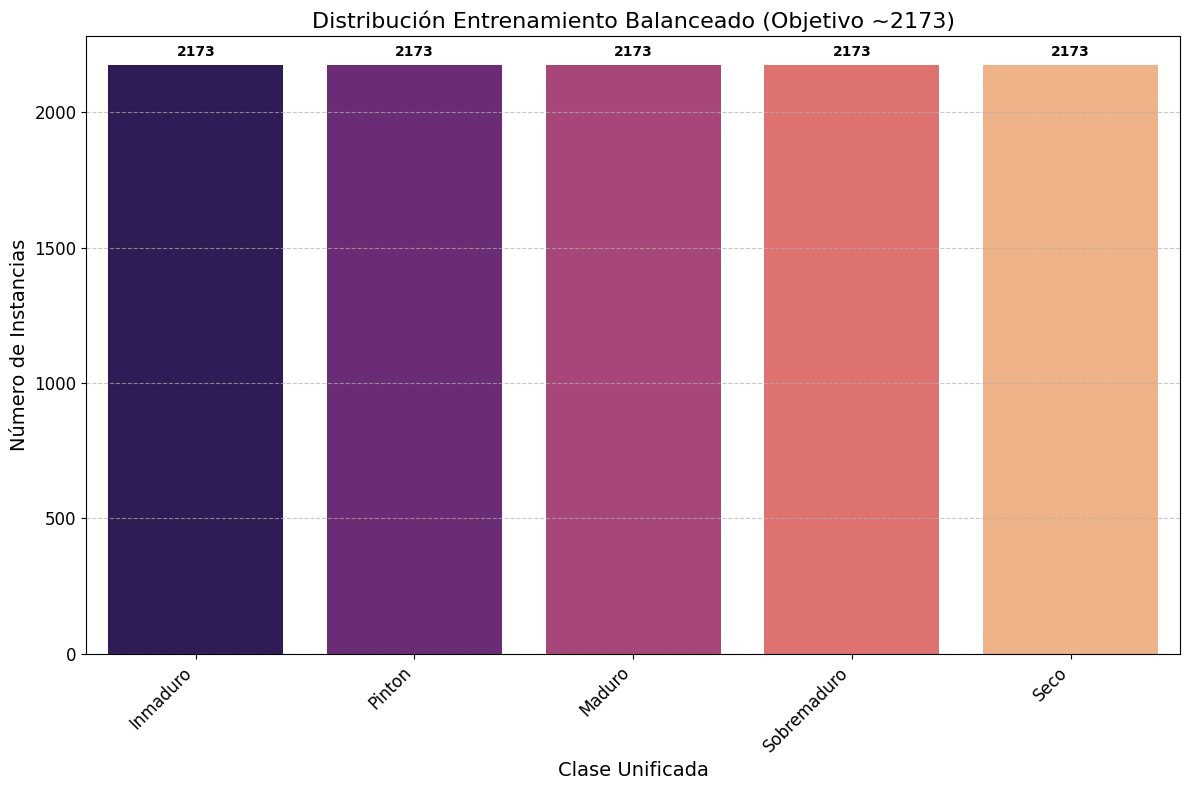

2025-06-07 01:41:30,987 INFO: --- Balanceo a nivel de instancia en directorio local /content/dataset_instance_balanced_temp completado. ---
2025-06-07 01:41:30,988 INFO: Verifica los conteos del set de entrenamiento. Clases mayoritarias deberían tener alrededor de 2173 instancias.


--- Balanceo completado. El dataset balanceado está en: /content/dataset_instance_balanced_temp ---


In [ ]:
# --- CELDA 3: BALANCEO A NIVEL DE INSTANCIA (LOCAL) ---

from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import os
import shutil
import random
import logging

# --- 0. Configuración de Logging ---
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s",
    force=True
)
print("--- CELDA 3: BALANCEO A NIVEL DE INSTANCIA (LOCAL) ---")
logging.info("--- CELDA 3: BALANCEO A NIVEL DE INSTANCIA (LOCAL) ---")

# --- 1. Definiciones Clave y Verificaciones ---

# Directorio de ENTRADA: Dataset unificado local (resultado de Celda 2)
if 'LOCAL_UNIFIED_DIR' not in globals() or not isinstance(LOCAL_UNIFIED_DIR, Path) or not LOCAL_UNIFIED_DIR.exists():
    logging.error(f"ERROR CRÍTICO: LOCAL_UNIFIED_DIR no está definido o no existe. Ejecuta la Celda 2 primero.")
    raise NameError("LOCAL_UNIFIED_DIR no definido o no existe.")
logging.info(f"Directorio de entrada (dataset unificado): {LOCAL_UNIFIED_DIR}")

# Nuevo directorio LOCAL para el dataset balanceado por instancias (temporal en Colab)
LOCAL_INSTANCE_BALANCED_DIR = Path("/content/dataset_instance_balanced_temp")
LOCAL_INSTANCE_BALANCED_DIR.mkdir(parents=True, exist_ok=True)
logging.info(f"El dataset balanceado por instancias (temporal, local) se guardará en: {LOCAL_INSTANCE_BALANCED_DIR}")

# Cargar UNIFIED_CLASS_LIST y UNIFIED_CLASS_TO_IDX (deberían estar definidas)
if 'UNIFIED_CLASS_LIST' not in globals() or 'UNIFIED_CLASS_TO_IDX' not in globals():
    logging.warning("UNIFIED_CLASS_LIST o UNIFIED_CLASS_TO_IDX no definidas globalmente. Intentando cargar desde YAML de LOCAL_UNIFIED_DIR...")
    local_unified_yaml_path = LOCAL_UNIFIED_DIR / "data_unified_local.yaml"
    if local_unified_yaml_path.exists():
        try:
            with open(local_unified_yaml_path, 'r') as f:
                unified_data_config_local = yaml.safe_load(f)
                UNIFIED_CLASS_LIST = unified_data_config_local.get('names', [])
            if UNIFIED_CLASS_LIST:
                UNIFIED_CLASS_TO_IDX = {name: i for i, name in enumerate(UNIFIED_CLASS_LIST)}
                logging.info(f"Lista de clases y mapa cargados desde {local_unified_yaml_path}: {UNIFIED_CLASS_LIST}")
            else:
                logging.error(f"No se pudo cargar UNIFIED_CLASS_LIST desde {local_unified_yaml_path}. Define manualmente.")
                raise ValueError(f"No se pudo cargar UNIFIED_CLASS_LIST desde {local_unified_yaml_path}")
        except Exception as e_yaml:
            logging.error(f"Error cargando YAML para clases: {e_yaml}. Define UNIFIED_CLASS_LIST manualmente.")
            raise ValueError(f"Error cargando YAML para clases: {e_yaml}")
    else:
        logging.error(f"Archivo YAML {local_unified_yaml_path} no encontrado. Define UNIFIED_CLASS_LIST manualmente.")
        raise FileNotFoundError(f"Archivo YAML {local_unified_yaml_path} no encontrado.")
else:
    logging.info(f"Usando UNIFIED_CLASS_LIST definida globalmente: {UNIFIED_CLASS_LIST}")


# --- 2. Preparación del Nuevo Directorio de Salida LOCAL ---
lib_images_dir = LOCAL_INSTANCE_BALANCED_DIR / "images"
lib_labels_dir = LOCAL_INSTANCE_BALANCED_DIR / "labels"
# Limpiar y crear directorios de destino para el dataset balanceado
for split in ["train", "valid"]:
    (lib_images_dir / split).mkdir(parents=True, exist_ok=True)
    for f_path in (lib_images_dir / split).glob('*'): f_path.unlink(missing_ok=True) # Limpiar archivos previos si existen
    (lib_labels_dir / split).mkdir(parents=True, exist_ok=True)
    for f_path in (lib_labels_dir / split).glob('*'): f_path.unlink(missing_ok=True) # Limpiar archivos previos si existen
logging.info(f"Directorio local para dataset balanceado por instancias preparado en: {LOCAL_INSTANCE_BALANCED_DIR}")


# --- 3. Copiar Conjunto de Validación (sin cambios) y Todas las Imágenes de Entrenamiento ---
# El conjunto de validación se copia tal cual, no se balancea.
source_local_valid_img_dir = LOCAL_UNIFIED_DIR / "images" / "valid"
source_local_valid_lbl_dir = LOCAL_UNIFIED_DIR / "labels" / "valid"
lib_valid_img_dir = lib_images_dir / "valid"
lib_valid_lbl_dir = lib_labels_dir / "valid"

logging.info("Copiando conjunto de validación (imágenes y etiquetas) localmente...")
if source_local_valid_img_dir.exists():
    shutil.copytree(source_local_valid_img_dir, lib_valid_img_dir, dirs_exist_ok=True)
if source_local_valid_lbl_dir.exists():
    shutil.copytree(source_local_valid_lbl_dir, lib_valid_lbl_dir, dirs_exist_ok=True)
logging.info("Conjunto de validación copiado.")

# Las imágenes de entrenamiento se copian todas. Las etiquetas se filtrarán.
source_local_train_img_dir = LOCAL_UNIFIED_DIR / "images" / "train"
lib_train_img_dir = lib_images_dir / "train" # Destino de imágenes de entrenamiento
logging.info("Copiando TODAS las imágenes de entrenamiento localmente (las etiquetas se balancearán)...")
if source_local_train_img_dir.exists():
    shutil.copytree(source_local_train_img_dir, lib_train_img_dir, dirs_exist_ok=True)
logging.info("Imágenes de entrenamiento copiadas.")


# --- 4. Balanceo a Nivel de Instancia para Etiquetas de Entrenamiento (LOCALMENTE) ---
source_local_train_lbl_dir = LOCAL_UNIFIED_DIR / "labels" / "train" # Origen de etiquetas de entrenamiento
lib_train_lbl_dir = lib_labels_dir / "train" # Destino de etiquetas de entrenamiento balanceadas

if not source_local_train_lbl_dir.exists():
    logging.error(f"Directorio de etiquetas de entrenamiento fuente {source_local_train_lbl_dir} no encontrado. No se puede balancear.")
else:
    logging.info(f"Iniciando recolección de instancias para balanceo desde: {source_local_train_lbl_dir}")

    instances_by_class_local = defaultdict(list) # Almacena (image_stem, line_idx, line_content)
    initial_instance_counts_local = Counter()    # Conteo inicial de instancias por clase
    image_stems_in_local_train = set()           # Nombres base de imágenes de entrenamiento

    for lbl_file_path in source_local_train_lbl_dir.glob("*.txt"):
        image_stem = lbl_file_path.stem
        image_stems_in_local_train.add(image_stem)
        try:
            with open(lbl_file_path, 'r') as f:
                for line_idx, line_content in enumerate(f):
                    line_content_stripped = line_content.strip()
                    if not line_content_stripped: continue
                    parts = line_content_stripped.split()
                    if not parts: continue
                    class_idx = int(parts[0])
                    if 0 <= class_idx < len(UNIFIED_CLASS_LIST):
                        instances_by_class_local[class_idx].append((image_stem, line_idx, line_content_stripped))
                        initial_instance_counts_local[class_idx] += 1
        except Exception as e:
            logging.error(f"Error leyendo {lbl_file_path.name}: {e}")

    logging.info(f"Conteos iniciales de instancias en el set de entrenamiento (desde {LOCAL_UNIFIED_DIR}):")
    for i in range(len(UNIFIED_CLASS_LIST)):
        logging.info(f"  Clase '{UNIFIED_CLASS_LIST[i]}' (índice {i}): {initial_instance_counts_local.get(i, 0)}")

    # Determinar TARGET_INSTANCES_PER_CLASS basado en la clase 'Seco'
    TARGET_INSTANCES_PER_CLASS = 0
    seco_class_name = 'Seco'
    if seco_class_name in UNIFIED_CLASS_TO_IDX:
        seco_class_idx = UNIFIED_CLASS_TO_IDX[seco_class_name]
        target_instances_for_seco = initial_instance_counts_local.get(seco_class_idx, 0)

        if target_instances_for_seco > 0:
            TARGET_INSTANCES_PER_CLASS = target_instances_for_seco
            logging.info(f"Clase minoritaria '{seco_class_name}' (índice {seco_class_idx}) tiene {target_instances_for_seco} instancias en entrenamiento.")
        else:
            logging.warning(f"ADVERTENCIA: La clase '{seco_class_name}' tiene 0 instancias en entrenamiento.")
            # Fallback: usar el mínimo conteo de cualquier clase que tenga > 0 instancias
            valid_counts = [count for count in initial_instance_counts_local.values() if count > 0]
            if valid_counts:
                TARGET_INSTANCES_PER_CLASS = min(valid_counts)
                logging.warning(f"Usando el mínimo conteo de otra clase como objetivo: {TARGET_INSTANCES_PER_CLASS} instancias.")
            else:
                TARGET_INSTANCES_PER_CLASS = 100 # Un default muy bajo si no hay instancias en absoluto
                logging.error(f"ERROR: No hay instancias en ninguna clase del set de entrenamiento. Usando default {TARGET_INSTANCES_PER_CLASS}.")
    else:
        logging.error(f"ERROR: Clase '{seco_class_name}' no encontrada en UNIFIED_CLASS_TO_IDX. No se puede determinar el objetivo de balanceo.")
        # Podrías decidir detener el script aquí o usar otro fallback
        raise ValueError(f"Clase '{seco_class_name}' no definida para determinar el objetivo de balanceo.")

    logging.info(f"Objetivo de balanceo: Aproximadamente {TARGET_INSTANCES_PER_CLASS} instancias por clase.")

    # Marcar instancias para eliminar
    lines_to_delete_markers_local = set() # Almacena (image_stem, original_line_idx)
    for class_idx_to_balance in range(len(UNIFIED_CLASS_LIST)):
        current_class_count = initial_instance_counts_local.get(class_idx_to_balance, 0)
        class_name_to_balance = UNIFIED_CLASS_LIST[class_idx_to_balance]

        if current_class_count > TARGET_INSTANCES_PER_CLASS:
            num_to_remove = current_class_count - TARGET_INSTANCES_PER_CLASS
            logging.info(f"  Clase '{class_name_to_balance}' (idx {class_idx_to_balance}): tiene {current_class_count}. Se marcarán {num_to_remove} para eliminación.")

            instances_of_this_class = instances_by_class_local[class_idx_to_balance]
            random.shuffle(instances_of_this_class) # Barajar para eliminar aleatoriamente

            for i_instance in range(num_to_remove):
                img_stem, orig_line_idx, _ = instances_of_this_class[i_instance]
                lines_to_delete_markers_local.add((img_stem, orig_line_idx))
        else:
            logging.info(f"  Clase '{class_name_to_balance}' (idx {class_idx_to_balance}): tiene {current_class_count}. No se eliminarán (objetivo {TARGET_INSTANCES_PER_CLASS}).")

    # Reescribir archivos de etiquetas de entrenamiento, omitiendo las líneas marcadas
    logging.info(f"Reescribiendo archivos de etiquetas de entrenamiento (balanceados) en: {lib_train_lbl_dir}")
    num_labels_rewritten = 0
    for image_stem_to_rewrite in image_stems_in_local_train:
        original_lbl_file_path = source_local_train_lbl_dir / f"{image_stem_to_rewrite}.txt"
        new_balanced_lbl_path = lib_train_lbl_dir / f"{image_stem_to_rewrite}.txt"
        kept_lines_for_file = []

        if original_lbl_file_path.exists():
            try:
                with open(original_lbl_file_path, 'r') as f_orig_lbl:
                    for line_idx, line_content_orig in enumerate(f_orig_lbl):
                        line_content_orig_stripped = line_content_orig.strip()
                        if not line_content_orig_stripped: continue
                        # Solo mantener la línea si NO está marcada para eliminación
                        if (image_stem_to_rewrite, line_idx) not in lines_to_delete_markers_local:
                            kept_lines_for_file.append(line_content_orig_stripped)
            except Exception as e_rewrite_read:
                logging.error(f"Error procesando para reescritura {original_lbl_file_path.name}: {e_rewrite_read}")

        # Escribir el nuevo archivo de etiqueta solo si contiene alguna línea (para no tener archivos vacíos innecesarios)
        # Sin embargo, las imágenes correspondientes ya fueron copiadas. Si un archivo de etiqueta queda vacío,
        # YOLO podría interpretarlo como una imagen sin objetos.
        # Por consistencia con el copiado de todas las imágenes, es mejor crear el archivo de etiqueta, incluso si está vacío.
        try:
            with open(new_balanced_lbl_path, 'w') as f_new_balanced_lbl:
                if kept_lines_for_file: # Solo escribir si hay algo que escribir
                    f_new_balanced_lbl.write("\n".join(kept_lines_for_file) + "\n")
            num_labels_rewritten +=1
        except Exception as e_rewrite_write:
            logging.error(f"Error escribiendo nuevo archivo de etiqueta {new_balanced_lbl_path.name}: {e_rewrite_write}")

    logging.info(f"Proceso de reescritura de {num_labels_rewritten} etiquetas de entrenamiento (local) completado.")

# --- 5. Creación del `data.yaml` para el Dataset Balanceado LOCAL ---
lib_data_yaml_content = {
    'path': str(LOCAL_INSTANCE_BALANCED_DIR.resolve()),
    'train': 'images/train',
    'val': 'images/valid',
    'names': UNIFIED_CLASS_LIST
}
lib_data_yaml_path = LOCAL_INSTANCE_BALANCED_DIR / "data_instance_balanced_local.yaml"
try:
    with open(lib_data_yaml_path, 'w') as f:
        yaml.dump(lib_data_yaml_content, f, sort_keys=False, indent=2, default_flow_style=False)
    logging.info(f"Archivo '{lib_data_yaml_path.name}' creado en {LOCAL_INSTANCE_BALANCED_DIR}")
except Exception as e:
    logging.error(f"Error escribiendo YAML balanceado local: {e}")

# --- 6. Análisis del Nuevo Dataset Balanceado LOCAL (Solo Train set) ---
final_lib_counts_train = Counter() # Conteos solo para el set de entrenamiento balanceado
images_with_class_lib_train = {i: set() for i in range(len(UNIFIED_CLASS_LIST))}

if lib_train_lbl_dir.exists():
    for lbl_file in lib_train_lbl_dir.glob("*.txt"):
        image_stem_final_count = lbl_file.stem
        classes_in_this_file_final = set()
        try:
            with open(lbl_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:
                        class_idx = int(parts[0])
                        if 0 <= class_idx < len(UNIFIED_CLASS_LIST):
                            final_lib_counts_train[class_idx] += 1
                            classes_in_this_file_final.add(class_idx)
            for cls_idx_final in classes_in_this_file_final:
                images_with_class_lib_train[cls_idx_final].add(image_stem_final_count)
        except Exception as e:
            logging.error(f"Error leyendo etiqueta final {lbl_file.name} para conteo: {e}")

print(f"\n--- Distribución de Clases en el Set de ENTRENAMIENTO LOCAL Balanceado ({LOCAL_INSTANCE_BALANCED_DIR / 'labels/train'}) ---")
logging.info(f"--- Distribución de Clases en el Set de ENTRENAMIENTO LOCAL Balanceado ---")
if 'TARGET_INSTANCES_PER_CLASS' in locals() and TARGET_INSTANCES_PER_CLASS > 0:
    print(f"--- (Objetivo: ~{TARGET_INSTANCES_PER_CLASS} instancias por clase) ---")
else:
    print(f"--- (Objetivo de instancias no definido o cero) ---")


if not UNIFIED_CLASS_LIST: print("Lista de clases no definida.")
elif not final_lib_counts_train: print("No se encontraron etiquetas en el entrenamiento balanceado local.")
else:
    for class_idx_final_count in range(len(UNIFIED_CLASS_LIST)):
        class_name_final_count = UNIFIED_CLASS_LIST[class_idx_final_count]
        instance_count_final = final_lib_counts_train.get(class_idx_final_count, 0)
        image_count_final = len(images_with_class_lib_train.get(class_idx_final_count, set()))
        print(f"Clase '{class_name_final_count}' (índice {class_idx_final_count}): {instance_count_final} instancias en {image_count_final} imágenes")
        logging.info(f"Clase '{class_name_final_count}' (índice {class_idx_final_count}): {instance_count_final} instancias en {image_count_final} imágenes")

    plot_class_names_lib = UNIFIED_CLASS_LIST
    plot_counts_lib = [final_lib_counts_train.get(idx, 0) for idx in range(len(UNIFIED_CLASS_LIST))]
    if any(c > 0 for c in plot_counts_lib): # Solo graficar si hay datos
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x=plot_class_names_lib, y=plot_counts_lib, hue=plot_class_names_lib, palette="magma", legend=False)
        if 'TARGET_INSTANCES_PER_CLASS' in locals() and TARGET_INSTANCES_PER_CLASS > 0:
             plt.title(f"Distribución Entrenamiento Balanceado (Objetivo ~{TARGET_INSTANCES_PER_CLASS})", fontsize=16)
        else:
            plt.title(f"Distribución Entrenamiento Balanceado", fontsize=16)
        plt.xlabel("Clase Unificada", fontsize=14)
        plt.ylabel("Número de Instancias", fontsize=14)
        plt.xticks(rotation=45, ha="right", fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        max_val_plot = max(plot_counts_lib) if plot_counts_lib else 0
        for i_bar_plot, v_bar_plot in enumerate(plot_counts_lib):
            if v_bar_plot > 0:
                 ax.text(i_bar_plot, v_bar_plot + (0.01 * max_val_plot) + 1, str(v_bar_plot), color='black', ha='center', va='bottom', fontweight='bold', fontsize=10)
        plt.tight_layout()
        plt.show()
    else:
        logging.warning("No se pudo generar gráfica para el dataset local balanceado (entrenamiento).")

logging.info(f"--- Balanceo a nivel de instancia en directorio local {LOCAL_INSTANCE_BALANCED_DIR} completado. ---")
if 'TARGET_INSTANCES_PER_CLASS' in locals() and TARGET_INSTANCES_PER_CLASS > 0:
    logging.info(f"Verifica los conteos del set de entrenamiento. Clases mayoritarias deberían tener alrededor de {TARGET_INSTANCES_PER_CLASS} instancias.")
print(f"--- Balanceo completado. El dataset balanceado está en: {LOCAL_INSTANCE_BALANCED_DIR} ---")

In [ ]:
# --- CELDA 4: GUARDAR DATASET BALANCEADO FINAL EN GOOGLE DRIVE ---

from pathlib import Path
import shutil
import logging
import os

# --- 0. Configuración de Logging ---
# Re-configurar logging para esta celda para asegurar salida
try:
    logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s: %(message)s", force=True)
except TypeError: # Fallback para versiones de Python < 3.8
    if not logging.getLogger().hasHandlers():
         logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s: %(message)s")
    else:
         logging.getLogger().setLevel(logging.INFO)
print("--- CELDA 4: GUARDAR DATASET BALANCEADO EN GOOGLE DRIVE ---")
logging.info("--- CELDA 4: GUARDAR DATASET BALANCEADO EN GOOGLE DRIVE ---")

# --- 1. Definiciones Clave (¡VERIFICA Y AJUSTA LA RUTA DE DESTINO!) ---

# Directorio Fuente LOCAL (salida de Celda 3)
LOCAL_INSTANCE_BALANCED_DIR = Path("/content/dataset_instance_balanced_temp") # Debería coincidir con la salida de Celda 3

# Directorio DESTINO en Google Drive
# !!! IMPORTANTE: Ajusta esta ruta al nombre y ubicación final deseados en tu Google Drive !!!
# Por ejemplo, considera un nombre que refleje el balanceo actual (~2503 instancias):
# FINAL_BALANCED_DRIVE_PATH = Path("/content/drive/MyDrive/Coffee_Final_Balanced_Approx2503")
# O usa la variable definida en tu Celda 1 si prefieres mantener esa ruta:
# FINAL_BALANCED_DRIVE_PATH = FINAL_BALANCED_DATASET_ON_DRIVE # (Si FINAL_BALANCED_DATASET_ON_DRIVE está definida globalmente)

# Para este ejemplo, usaré un placeholder. Reemplázalo con tu ruta deseada:
FINAL_BALANCED_DRIVE_PATH = Path("/content/drive/MyDrive/SegDatasetCafeBalanceado") # <--- ¡¡¡AJUSTA ESTA RUTA!!!
logging.info(f"ADVERTENCIA: Asegúrate que FINAL_BALANCED_DRIVE_PATH ('{FINAL_BALANCED_DRIVE_PATH}') es la ruta correcta en tu Drive.")


# --- Imprimir rutas para verificación ---
print(f"Ruta Fuente Local: {LOCAL_INSTANCE_BALANCED_DIR}")
print(f"Ruta Destino en Drive: {FINAL_BALANCED_DRIVE_PATH}")
logging.info(f"Ruta Fuente Local: {LOCAL_INSTANCE_BALANCED_DIR}")
logging.info(f"Ruta Destino en Drive: {FINAL_BALANCED_DRIVE_PATH}")

# --- 2. Verificaciones Previas ---
if not LOCAL_INSTANCE_BALANCED_DIR.exists():
    error_msg_src = f"ERROR CRÍTICO: El directorio fuente local {LOCAL_INSTANCE_BALANCED_DIR} no existe. Ejecuta la Celda 3 primero."
    print(error_msg_src)
    logging.error(error_msg_src)
    raise FileNotFoundError(error_msg_src)

if str(FINAL_BALANCED_DRIVE_PATH) == "/content/drive/MyDrive/SegDatasetCafeBalanceado" and \
   "Coffee_Final_Balanced_Dataset" in str(FINAL_BALANCED_DRIVE_PATH): # Chequeo simple del placeholder
    prompt_msg = (f"CONFIRMACIÓN: El destino en Drive es '{FINAL_BALANCED_DRIVE_PATH}'. "
                  "¿Es esta la ruta correcta y deseas continuar? (s/n): ")
    # Descomenta la siguiente sección si quieres una confirmación interactiva en Colab
    # confirm = input(prompt_msg)
    # if confirm.lower() != 's':
    #     abort_msg = "Operación cancelada por el usuario. Por favor, ajusta FINAL_BALANCED_DRIVE_PATH."
    #     print(abort_msg)
    #     logging.info(abort_msg)
    #     raise InterruptedError(abort_msg)
    print(f"AVISO: Usando la ruta de destino: {FINAL_BALANCED_DRIVE_PATH}. Si no es correcta, detén la celda y ajústala.")


logging.info(f"Fuente local confirmada: {LOCAL_INSTANCE_BALANCED_DIR}")
logging.info(f"Destino en Drive configurado para: {FINAL_BALANCED_DRIVE_PATH}")

# --- 3. Preparar Directorio Destino en Drive ---
if FINAL_BALANCED_DRIVE_PATH.exists():
    logging.warning(f"El directorio destino {FINAL_BALANCED_DRIVE_PATH} ya existe. Se eliminará su contenido para una copia limpia.")
    print(f"ADVERTENCIA: El directorio destino {FINAL_BALANCED_DRIVE_PATH} ya existe. Se eliminará su contenido.")
    try:
        shutil.rmtree(FINAL_BALANCED_DRIVE_PATH)
        logging.info(f"Directorio {FINAL_BALANCED_DRIVE_PATH} eliminado exitosamente.")
        print(f"Directorio {FINAL_BALANCED_DRIVE_PATH} eliminado exitosamente.")
    except Exception as e_rm:
        error_msg_rm = f"No se pudo eliminar el directorio {FINAL_BALANCED_DRIVE_PATH}: {e_rm}. Por favor, elimina o renombra manualmente y reintenta."
        print(f"ERROR: {error_msg_rm}")
        logging.error(error_msg_rm)
        raise RuntimeError(error_msg_rm) # Detener si no se puede limpiar el destino

try:
    FINAL_BALANCED_DRIVE_PATH.mkdir(parents=True, exist_ok=True)
    logging.info(f"Directorio destino {FINAL_BALANCED_DRIVE_PATH} creado/preparado en Google Drive.")
    print(f"Directorio destino {FINAL_BALANCED_DRIVE_PATH} creado/preparado en Google Drive.")
except Exception as e_mkdir:
    error_msg_mkdir = f"No se pudo crear el directorio destino {FINAL_BALANCED_DRIVE_PATH}: {e_mkdir}"
    print(f"ERROR: {error_msg_mkdir}")
    logging.error(error_msg_mkdir)
    raise RuntimeError(error_msg_mkdir) # Detener si no se puede crear el destino

# --- 4. Copiar el contenido del directorio local al directorio de Drive ---
source_path_str = str(LOCAL_INSTANCE_BALANCED_DIR)
destination_path_str = str(FINAL_BALANCED_DRIVE_PATH)

logging.info(f"Iniciando la copia de '{source_path_str}' a '{destination_path_str}'...")
print(f"Iniciando la copia de '{source_path_str}' a '{destination_path_str}' (esto puede tardar)...")
try:
    # El método de copiar item por item que tenías es robusto.
    # shutil.copytree(source_path_str, destination_path_str, dirs_exist_ok=True)
    # sería más conciso si el directorio destino ya está vacío y creado.
    # Dado que limpiamos explícitamente, podemos usar copytree de forma más directa o mantener tu lógica.
    # Mantendré tu lógica item por item por ahora ya que la probaste.

    for item_name in os.listdir(source_path_str):
        source_item_path = os.path.join(source_path_str, item_name)
        destination_item_path = os.path.join(destination_path_str, item_name)

        if os.path.isdir(source_item_path):
            # Para copytree, el directorio destino NO debe existir previamente si no se usa dirs_exist_ok=True.
            # Dado que FINAL_BALANCED_DRIVE_PATH ya está creado, destination_item_path
            # (que es FINAL_BALANCED_DRIVE_PATH/item_name) no debería existir.
            shutil.copytree(source_item_path, destination_item_path)
        else: # es un archivo
            shutil.copy2(source_item_path, destination_item_path)

    logging.info(f"✅ Copia completada exitosamente a {FINAL_BALANCED_DRIVE_PATH}")
    logging.info(f"Puedes encontrarlo en Drive > Mi Unidad > {FINAL_BALANCED_DRIVE_PATH.relative_to('/content/drive/MyDrive')}") # Asume que MyDrive es la raíz
    print(f"✅ Copia completada exitosamente a {FINAL_BALANCED_DRIVE_PATH}")
    print("¡Tu dataset balanceado ahora está guardado de forma permanente en Google Drive!")

except Exception as e_copy:
    error_msg_copy = f"❌ Error durante la copia a Google Drive: {e_copy}. Verifica la carpeta destino."
    print(f"❌ {error_msg_copy}")
    logging.error(error_msg_copy)

print("\n--- FIN DE CELDA 4 ---")

2025-06-07 01:43:40,470 INFO: --- CELDA 4: GUARDAR DATASET BALANCEADO EN GOOGLE DRIVE ---
2025-06-07 01:43:40,472 INFO: ADVERTENCIA: Asegúrate que FINAL_BALANCED_DRIVE_PATH ('/content/drive/MyDrive/SegDatasetCafeBalanceado') es la ruta correcta en tu Drive.
2025-06-07 01:43:40,473 INFO: Ruta Fuente Local: /content/dataset_instance_balanced_temp
2025-06-07 01:43:40,475 INFO: Ruta Destino en Drive: /content/drive/MyDrive/SegDatasetCafeBalanceado
2025-06-07 01:43:40,476 INFO: Fuente local confirmada: /content/dataset_instance_balanced_temp
2025-06-07 01:43:40,477 INFO: Destino en Drive configurado para: /content/drive/MyDrive/SegDatasetCafeBalanceado
2025-06-07 01:43:40,498 INFO: Directorio destino /content/drive/MyDrive/SegDatasetCafeBalanceado creado/preparado en Google Drive.
2025-06-07 01:43:40,500 INFO: Iniciando la copia de '/content/dataset_instance_balanced_temp' a '/content/drive/MyDrive/SegDatasetCafeBalanceado'...


--- CELDA 4: GUARDAR DATASET BALANCEADO EN GOOGLE DRIVE ---
Ruta Fuente Local: /content/dataset_instance_balanced_temp
Ruta Destino en Drive: /content/drive/MyDrive/SegDatasetCafeBalanceado
Directorio destino /content/drive/MyDrive/SegDatasetCafeBalanceado creado/preparado en Google Drive.
Iniciando la copia de '/content/dataset_instance_balanced_temp' a '/content/drive/MyDrive/SegDatasetCafeBalanceado' (esto puede tardar)...


2025-06-07 01:46:07,085 INFO: ✅ Copia completada exitosamente a /content/drive/MyDrive/SegDatasetCafeBalanceado
2025-06-07 01:46:07,088 INFO: Puedes encontrarlo en Drive > Mi Unidad > SegDatasetCafeBalanceado


✅ Copia completada exitosamente a /content/drive/MyDrive/SegDatasetCafeBalanceado
¡Tu dataset balanceado ahora está guardado de forma permanente en Google Drive!

--- FIN DE CELDA 4 ---


2025-06-01 22:37:26,300 INFO: --- ANÁLISIS DEL DATASET BALANCEADO FINAL EN DRIVE ---
2025-06-01 22:37:26,302 INFO: Ruta del dataset en Drive a analizar: /content/drive/MyDrive/DatasetCafeBalanceado
2025-06-01 22:37:26,311 INFO: Nombres de clases cargados desde 'data_instance_balanced_local.yaml': ['Inmaduro', 'Pinton', 'Maduro', 'Sobremaduro', 'Seco']
2025-06-01 22:37:26,315 INFO: Analizando etiquetas de entrenamiento en: /content/drive/MyDrive/DatasetCafeBalanceado/labels/train
2025-06-01 22:37:26,482 INFO: Se encontraron 6422 archivos de etiquetas .txt para analizar en el set de entrenamiento de Drive.


--- ANÁLISIS DEL DATASET BALANCEADO FINAL EN DRIVE ---
Analizando dataset en Drive: /content/drive/MyDrive/DatasetCafeBalanceado
Nombres de clases cargados: ['Inmaduro', 'Pinton', 'Maduro', 'Sobremaduro', 'Seco']
Analizando 6422 archivos de etiquetas de entrenamiento desde Drive...


2025-06-01 22:39:40,322 INFO: Análisis de 6422/6422 archivos de etiquetas de Drive completado.
2025-06-01 22:39:40,324 INFO: --- Análisis del Set de ENTRENAMIENTO en Drive: /content/drive/MyDrive/DatasetCafeBalanceado ---



--- Análisis del Set de ENTRENAMIENTO en Drive: /content/drive/MyDrive/DatasetCafeBalanceado ---


2025-06-01 22:39:41,089 INFO: Clase 'Inmaduro' (índice 0):
2025-06-01 22:39:41,090 INFO:   - Total de instancias (etiquetas): 2503
2025-06-01 22:39:41,093 INFO:   - Presente en: 1719 imágenes de entrenamiento únicas
2025-06-01 22:39:41,095 INFO:   - Promedio de instancias por imagen: 1.46
2025-06-01 22:39:41,098 INFO: Clase 'Pinton' (índice 1):
2025-06-01 22:39:41,101 INFO:   - Total de instancias (etiquetas): 2503
2025-06-01 22:39:41,102 INFO:   - Presente en: 1523 imágenes de entrenamiento únicas
2025-06-01 22:39:41,105 INFO:   - Promedio de instancias por imagen: 1.64
2025-06-01 22:39:41,108 INFO: Clase 'Maduro' (índice 2):
2025-06-01 22:39:41,109 INFO:   - Total de instancias (etiquetas): 2503
2025-06-01 22:39:41,113 INFO:   - Presente en: 1576 imágenes de entrenamiento únicas
2025-06-01 22:39:41,116 INFO:   - Promedio de instancias por imagen: 1.59
2025-06-01 22:39:41,121 INFO: Clase 'Sobremaduro' (índice 3):
2025-06-01 22:39:41,124 INFO:   - Total de instancias (etiquetas): 2503


Total de imágenes encontradas en 'images/train' de Drive: 6422
Total de archivos de etiquetas analizados en 'labels/train' de Drive: 6422

Clase 'Inmaduro' (índice 0):
  - Total de instancias (etiquetas): 2503
  - Presente en: 1719 imágenes de entrenamiento únicas
  - Promedio de instancias por imagen (donde la clase está presente): 1.46
----------------------------------------
Clase 'Pinton' (índice 1):
  - Total de instancias (etiquetas): 2503
  - Presente en: 1523 imágenes de entrenamiento únicas
  - Promedio de instancias por imagen (donde la clase está presente): 1.64
----------------------------------------
Clase 'Maduro' (índice 2):
  - Total de instancias (etiquetas): 2503
  - Presente en: 1576 imágenes de entrenamiento únicas
  - Promedio de instancias por imagen (donde la clase está presente): 1.59
----------------------------------------
Clase 'Sobremaduro' (índice 3):
  - Total de instancias (etiquetas): 2503
  - Presente en: 1333 imágenes de entrenamiento únicas
  - Promed

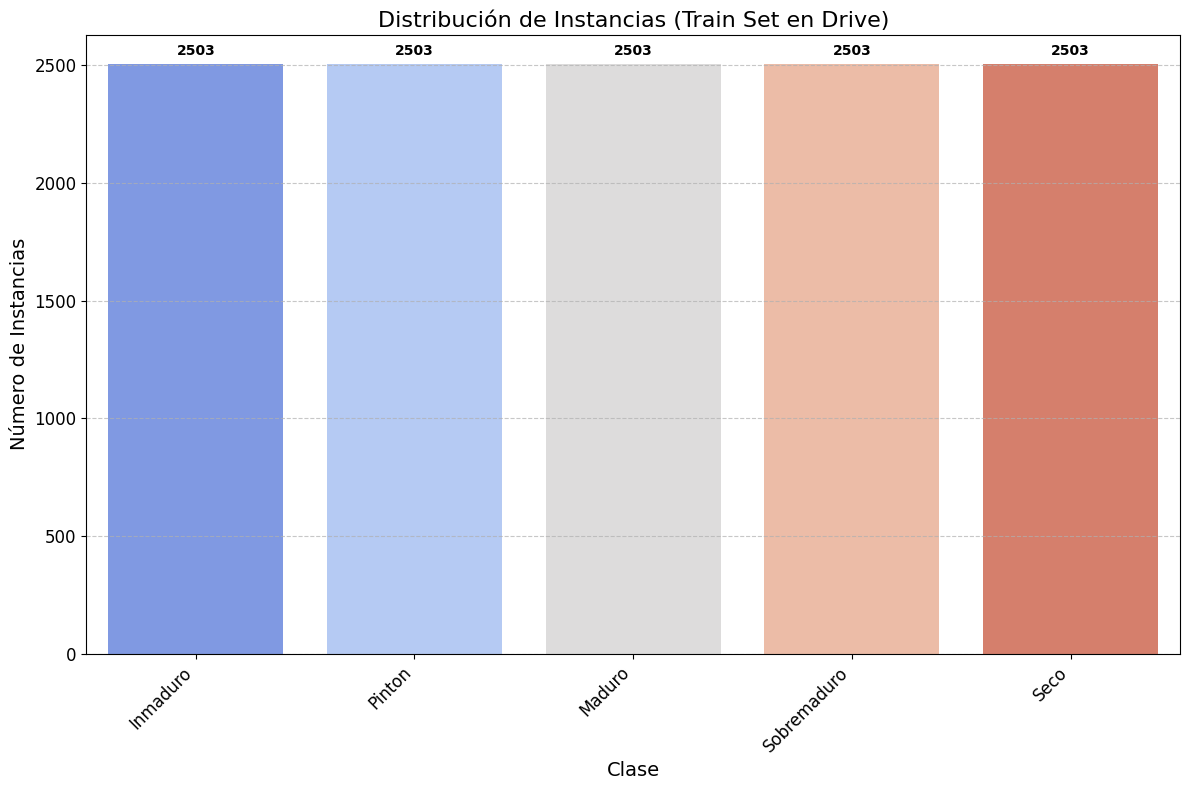

2025-06-01 22:39:41,521 INFO: --- FIN DEL ANÁLISIS DEL DATASET EN DRIVE ---



--- FIN DEL ANÁLISIS DEL DATASET EN DRIVE ---


In [ ]:
# --- CELDA DE ANÁLISIS DEL DATASET BALANCEADO FINAL EN DRIVE ---

import logging
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict # defaultdict ya estaba, Counter es bueno tenerlo explícito.
# import os # Path.glob es preferible para listar archivos de forma más controlada

# --- 0. Configuración de Logging ---
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s",
    force=True
)
print("--- ANÁLISIS DEL DATASET BALANCEADO FINAL EN DRIVE ---")
logging.info("--- ANÁLISIS DEL DATASET BALANCEADO FINAL EN DRIVE ---")

# --- 1. Definir la Ruta al Dataset Balanceado en Drive ---
# Esta es la ruta donde la Celda 4 guardó el dataset.
BALANCED_DATASET_PATH_ON_DRIVE = Path("/content/drive/MyDrive/DatasetCafeBalanceado") # AJUSTADO
logging.info(f"Ruta del dataset en Drive a analizar: {BALANCED_DATASET_PATH_ON_DRIVE}")
print(f"Analizando dataset en Drive: {BALANCED_DATASET_PATH_ON_DRIVE}")

# --- 2. Cargar Nombres de Clases desde el Archivo YAML del Dataset ---
CLASS_NAMES_FROM_YAML = []
# El script de balanceo (Celda 3) guardó el YAML como "data_instance_balanced_local.yaml".
yaml_file_name = "data_instance_balanced_local.yaml" # Nombre del YAML creado por Celda 3
dataset_yaml_path = BALANCED_DATASET_PATH_ON_DRIVE / yaml_file_name

if not BALANCED_DATASET_PATH_ON_DRIVE.exists():
    error_msg_ds_not_exist = f"ERROR CRÍTICO: El directorio del dataset ({BALANCED_DATASET_PATH_ON_DRIVE}) no existe en Drive."
    print(error_msg_ds_not_exist)
    logging.error(error_msg_ds_not_exist)
    raise FileNotFoundError(error_msg_ds_not_exist)
elif not dataset_yaml_path.exists():
    error_msg_yaml_not_exist = f"ERROR CRÍTICO: No se encontró el archivo YAML '{yaml_file_name}' en {BALANCED_DATASET_PATH_ON_DRIVE}."
    print(error_msg_yaml_not_exist)
    logging.error(error_msg_yaml_not_exist)
    # Considera definir CLASS_NAMES_FROM_YAML manualmente si sabes que el YAML falta pero conoces las clases.
    # CLASS_NAMES_FROM_YAML = ['Inmaduro', 'Pinton', 'Maduro', 'Sobremaduro', 'Seco'] # Fallback manual
    raise FileNotFoundError(error_msg_yaml_not_exist)
else:
    try:
        with open(dataset_yaml_path, 'r') as f:
            dataset_config = yaml.safe_load(f)
            CLASS_NAMES_FROM_YAML = dataset_config.get('names', [])
        if not CLASS_NAMES_FROM_YAML:
            error_msg_no_names = f"No se pudo leer la lista de 'names' desde {dataset_yaml_path} o está vacía."
            print(f"ERROR: {error_msg_no_names}")
            logging.error(error_msg_no_names)
            raise ValueError(error_msg_no_names)
        else:
            logging.info(f"Nombres de clases cargados desde '{dataset_yaml_path.name}': {CLASS_NAMES_FROM_YAML}")
            print(f"Nombres de clases cargados: {CLASS_NAMES_FROM_YAML}")
    except Exception as e_yaml_load:
        error_msg_yaml_exc = f"Error cargando o parseando {dataset_yaml_path}: {e_yaml_load}"
        print(f"ERROR: {error_msg_yaml_exc}")
        logging.error(error_msg_yaml_exc)
        raise RuntimeError(error_msg_yaml_exc)

# --- 3. Analizar Etiquetas e Imágenes del Conjunto de Entrenamiento desde Drive ---
train_labels_dir = BALANCED_DATASET_PATH_ON_DRIVE / "labels" / "train"
train_images_dir = BALANCED_DATASET_PATH_ON_DRIVE / "images" / "train"

instance_counts_from_drive = Counter()
images_per_class_from_drive = defaultdict(set)
total_training_label_files_found = 0
processed_training_label_files_count = 0

if not train_labels_dir.exists() or not train_labels_dir.is_dir():
    error_msg_train_lbl_dir = f"ERROR CRÍTICO: El directorio de etiquetas de entrenamiento ({train_labels_dir}) no existe en Drive."
    print(error_msg_train_lbl_dir)
    logging.error(error_msg_train_lbl_dir)
    # No se puede continuar si no hay etiquetas de entrenamiento
else:
    logging.info(f"Analizando etiquetas de entrenamiento en: {train_labels_dir}")

    label_files_on_drive = list(train_labels_dir.glob("*.txt"))
    total_training_label_files_found = len(label_files_on_drive)
    logging.info(f"Se encontraron {total_training_label_files_found} archivos de etiquetas .txt para analizar en el set de entrenamiento de Drive.")
    print(f"Analizando {total_training_label_files_found} archivos de etiquetas de entrenamiento desde Drive...")

    for lbl_file_path in label_files_on_drive:
        image_stem = lbl_file_path.stem
        processed_training_label_files_count += 1
        try:
            with open(lbl_file_path, 'r') as f:
                for line_num, line_content in enumerate(f):
                    parts = line_content.strip().split()
                    if parts:
                        try:
                            class_idx = int(parts[0])
                            if 0 <= class_idx < len(CLASS_NAMES_FROM_YAML):
                                instance_counts_from_drive[class_idx] += 1
                                images_per_class_from_drive[class_idx].add(image_stem)
                            else:
                                logging.warning(f"Índice de clase {class_idx} fuera de rango en {lbl_file_path.name} (línea {line_num+1}). Se ignora.")
                        except ValueError:
                            logging.warning(f"No se pudo convertir índice de clase a entero en {lbl_file_path.name} (línea {line_num+1}): '{line_content.strip()}'. Se ignora.")
        except Exception as e_read_lbl:
            logging.error(f"Error leyendo el archivo de etiqueta {lbl_file_path.name} desde Drive: {e_read_lbl}")

    logging.info(f"Análisis de {processed_training_label_files_count}/{total_training_label_files_found} archivos de etiquetas de Drive completado.")

# --- 4. Imprimir Resultados del Análisis en Drive ---
print(f"\n--- Análisis del Set de ENTRENAMIENTO en Drive: {BALANCED_DATASET_PATH_ON_DRIVE} ---")
logging.info(f"--- Análisis del Set de ENTRENAMIENTO en Drive: {BALANCED_DATASET_PATH_ON_DRIVE} ---")

if total_training_label_files_found == 0 and (not train_labels_dir.exists() or not train_labels_dir.is_dir()):
    print("No se analizaron archivos de etiquetas porque el directorio de entrenamiento no se encontró o estaba vacío.")
elif processed_training_label_files_count == 0 and total_training_label_files_found > 0 :
    print(f"Se encontraron {total_training_label_files_found} archivos de etiquetas, pero ninguno pudo ser procesado (revisa errores de lectura).")
elif not instance_counts_from_drive: # Si no se contaron instancias a pesar de procesar archivos
    print(f"Se procesaron {processed_training_label_files_count} archivos de etiquetas, pero no se encontraron instancias válidas.")
else:
    total_images_in_train_set_drive = 0
    if train_images_dir.exists() and train_images_dir.is_dir():
        # Contar archivos de imagen (asumiendo extensiones comunes)
        image_extensions = ['*.jpg', '*.jpeg', '*.png']
        image_files_in_drive_train = []
        for ext in image_extensions:
            image_files_in_drive_train.extend(list(train_images_dir.glob(ext)))
        total_images_in_train_set_drive = len(image_files_in_drive_train)

    print(f"Total de imágenes encontradas en 'images/train' de Drive: {total_images_in_train_set_drive}")
    print(f"Total de archivos de etiquetas analizados en 'labels/train' de Drive: {processed_training_label_files_count}\n")

    for class_idx_report in range(len(CLASS_NAMES_FROM_YAML)):
        class_name_report = CLASS_NAMES_FROM_YAML[class_idx_report]
        num_instances_report = instance_counts_from_drive.get(class_idx_report, 0)
        num_images_report = len(images_per_class_from_drive.get(class_idx_report, set()))

        print(f"Clase '{class_name_report}' (índice {class_idx_report}):")
        logging.info(f"Clase '{class_name_report}' (índice {class_idx_report}):")
        print(f"  - Total de instancias (etiquetas): {num_instances_report}")
        logging.info(f"  - Total de instancias (etiquetas): {num_instances_report}")
        print(f"  - Presente en: {num_images_report} imágenes de entrenamiento únicas")
        logging.info(f"  - Presente en: {num_images_report} imágenes de entrenamiento únicas")
        if num_images_report > 0:
            avg_instances_per_image_report = num_instances_report / num_images_report
            print(f"  - Promedio de instancias por imagen (donde la clase está presente): {avg_instances_per_image_report:.2f}")
            logging.info(f"  - Promedio de instancias por imagen: {avg_instances_per_image_report:.2f}")
        print("-" * 40)

# --- 5. Graficar Distribución de Instancias por Clase (desde Drive) ---
if CLASS_NAMES_FROM_YAML and instance_counts_from_drive:
    plot_class_names_final_drive = CLASS_NAMES_FROM_YAML
    plot_counts_final_drive = [instance_counts_from_drive.get(idx, 0) for idx in range(len(CLASS_NAMES_FROM_YAML))]

    if any(c > 0 for c in plot_counts_final_drive):
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x=plot_class_names_final_drive, y=plot_counts_final_drive, hue=plot_class_names_final_drive, palette="coolwarm", legend=False)
        plt.title(f"Distribución de Instancias (Train Set en Drive)", fontsize=16)
        plt.xlabel("Clase", fontsize=14)
        plt.ylabel("Número de Instancias", fontsize=14)
        plt.xticks(rotation=45, ha="right", fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        max_val_plot_drive = max(plot_counts_final_drive) if plot_counts_final_drive else 0
        for i_bar_drive, v_bar_drive in enumerate(plot_counts_final_drive):
            if v_bar_drive > 0:
                 ax.text(i_bar_drive, v_bar_drive + (0.01 * max_val_plot_drive) + 1, str(v_bar_drive), color='black', ha='center', va='bottom', fontweight='bold', fontsize=10)
        plt.tight_layout()
        plt.show()
    else:
        logging.info("No hay datos de conteo de instancias para graficar desde Drive.")
        print("No hay datos de instancias para graficar (todos los conteos son cero).")
elif CLASS_NAMES_FROM_YAML:
    logging.info("No se encontraron conteos de etiquetas en Drive para generar la gráfica.")
    print("No se encontraron conteos de etiquetas en Drive para generar la gráfica.")
else:
    logging.info("No se pudo generar la gráfica porque la lista de clases no está disponible.")
    print("No se pudo generar la gráfica (lista de clases no disponible).")

print("\n--- FIN DEL ANÁLISIS DEL DATASET EN DRIVE ---")
logging.info("--- FIN DEL ANÁLISIS DEL DATASET EN DRIVE ---")